# **Neural Network at work: the $\mathrm{D}^{+}_\mathrm{s}$ analysis**

The goal of this tutorial is to train and test a multi-class classification algorithm. The tutorial will focus on the reconstruction of the $\mathrm{D^{+}_{s}}$ meson ($\mathrm{c\bar{s}}$) signal in pp collisions with the data collected by ALICE in the first year of Run 3. 

The $\mathrm{D^{+}_{s}}$ meson has quite a short lifetime ($c\tau\sim151\mu\mathrm{m}$), so it cannot be detected directly. Therefore, we need to reconstruct it through its decay products. In this tutorial (as well as in the analyses performed by ALICE) we will reconstruct the $\mathrm{D^{+}_{s}}$ meson through its hadronic decay channel $\mathrm{D^{+}_{s} \rightarrow \mathrm{\phi} \pi^+ \rightarrow K^+ K^- \pi^-}$. _Machine learning_ (ML) algorithms are used to improve the selection of the interesting signal and the rejection of the uninteresting background (arising from the _combination_ of kaons and pions not produced from $\mathrm{D^+_s}$ decays: the _combinatorial background_).

The $\mathrm{D^{+}_{s}}$ mesons can be categorised as either _prompt_ (i.e. originating from charm quark hadronisation) or _non-prompt_ (i.e. originating from beauty-hadron decays). In this tutorial both these classes are considered. In particular, the ML algorithm is going to classify the $\mathrm{D^{+}_{s}}$ meson candidates as either prompt, non-prompt, or background.

Prompt candidates are produced very close to the primary vertex, while non-prompt candidates are produced at a displaced vertex (as beauty hadrons have a lifetime of about c\tau\sim500\mu\mathrm{m}), and therefore we can separate the two classes by looking at the distance between the primary and the D-meson decay vertex. More in general, we will be able to separate signal from background exploiting the _displaced topology_ of the $\mathrm{D^{+}_{s}}$ meson decay.

<img src="img/DsDecaySketch.png" 
     align="center" 
     width="900" />

### **File download**

The first step is to download all the samples we will need for the ML training and test. In Run 3, the tables produced by the analysis workflows in O2Physics can be saved locally as derived data via `TreeCreator` tasks in the form of ROOT `TTrees`. This format is easier to be handled for ML purposes. 

To spare time, the AO2D from hyperloop have been filtered and organised in _.parquet_ files. However, the `TTree` format can be employed as well following the same procedure presented below.

In [1]:
#!curl -L https://cernbox.cern.ch/s/bWelV02GFrfGAcC/download --output data/data_training.parquet
#!curl -L https://cernbox.cern.ch/s/ku9JRvffAusJ4Vo/download --output data/data_application.parquet
#!curl -L https://cernbox.cern.ch/s/WEeLWC9rlLrfZfJ/download --output data/non_prompt_ds.parquet
#!curl -L https://cernbox.cern.ch/s/P98CyjgMdsPwT6O/download --output data/prompt_ds.parquet


## Neural Network in a nutshell

SPIEGAZIONE SULLE NN

### **Required python packages**

We first import standard _python packages_ that will be used later on (mainly for plotting)

In [2]:
### standard python library for plotting
import matplotlib.pyplot as plt
plt.ioff()
plt.rcParams["figure.figsize"] = (10, 7)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

Then, we import the [hipe4ml](https://github.com/hipe4ml/hipe4ml) package.

This package developed in ALICE contains useful methods and classes for dealing with ML analyses.
Two main classes are implemented:
- `TreeHandler`, wrapping uproot and pandas methods: allows for conversion and handling of the training samples (more info about [pandas](https://pandas.pydata.org/) and [uproot](https://uproot.readthedocs.io/en/latest/index.html));
- `ModelHandler`, a common interface for many ML methods;
- `plot_utils`, containing a list of plotting methods to visualize the outcome of the ML analyses.
- `analysis_utils`, containing useful analysis functions

In [3]:
# import ML-related libraries
import xgboost as xgb # gradient boosting
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import plot_utils
from hipe4ml.analysis_utils import train_test_generator

In [4]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_ovo
from hipe4ml.tree_handler import TreeHandler 

### **Preparing the data set**

We now open the parquet files with the `TreeHandler` class to facilitate the handling of the data for ML purposes.  

In [5]:
# Load and preprocess the datasets
prompt_data = TreeHandler("data/prompt_ds.parquet")
non_prompt_data = TreeHandler("data/non_prompt_ds.parquet")
background_data = TreeHandler("data/data_training.parquet")

Then, we filter the datasets to select only the 2 < $p_\mathrm{T}$ < 4 GeV/_c_ interval to facilitate and speed up the training process. You can apply such a selection on $p_\mathrm{T}$ (`fPt` variable) using the `apply_preselections` method. 

Typically, the training is performed over several $p_\mathrm{T}$ intervals (e.g. [CERN-EP-2023-162](https://arxiv.org/abs/2308.04877)) to improve the classification, as the decay topology changes quite significantly with $p_\mathrm{T}$ due to the different _Lorentz boost_ of the $\mathrm{D^{+}_{s}}$ meson.

In [6]:
# Apply preselections
prompt_data.apply_preselections("2 < fPt < 4")
non_prompt_data.apply_preselections("2 < fPt < 4")
background_data.apply_preselections("2 < fPt < 4")

As said before, MC simulations are used to obtain a pure sample of signal candidates, while background candidates are obtained from real data. It is usually better to choose "true" data over simulations for the training to avoid eventual shortcomings in the MC, even though it is not always feasible (for example, we cannot use real data for signal examples, as we can't tell signal and background apart).

Typically, since we want to analyse the full dataset, we only use a fraction of the real data for developing our models. This can be done using the `get_subset` method of the `TreeHandler` class. This was already done for you in the parquet files, but you can do it yourself if you want to.

In [7]:
# we use only a fraction of the data for the training
background_data = background_data.get_subset(frac=1.0, rndm_state=42) # rndm_state is the seed for the random number generator. Useful so that we all have the same results

Furthermore, to avoid the inclusion of signal candidates in the background sample, we apply a preselection to the data sample, by selecting only the _sidebands_ of the invariant-mass distribution (`'fM'`) of the candidates. The sideband regions are typically defined as the regions at least 3 $\sigma$ away from the signal peak. In the case of the $\mathrm{D^{+}_{s}}$ meson, you’ll notice that **the sidebands are not symmetric around the peak** — there’s an interesting reason for this, which will become clear by the end of the tutorial!

In [8]:
# Apply the preselection here! We only consider the sideband regions in data (M < 1.75 GeV/c^2 or M > 2.1 GeV/c^2)
background_data.apply_preselections("fM < 1.75 or fM > 2.1")

Another important aspect to consider is the _imbalance_ between the number of signal and background candidates. This imbalance can lead to a bias in the classification, as the algorithm may tend to classify all candidates as the majority class. To mitigate this issue, we can equalize the number of signal and background candidates in the training sample. This can be done using the `get_subset` method.

In [9]:
# Balance Dataset
print("Number of prompt Ds examples in MC: ", prompt_data.get_n_cand())
print("Number of non-prompt Ds examples in MC: ", non_prompt_data.get_n_cand())
print("Number of background examples in data: ", background_data.get_n_cand())
number_cands_to_keep = min(prompt_data.get_n_cand(), non_prompt_data.get_n_cand(), background_data.get_n_cand())

Number of prompt Ds examples in MC:  65514
Number of non-prompt Ds examples in MC:  196151
Number of background examples in data:  263096


You can now try to equalise the number of examples of the hdl_mc_prompt, hdl_mc_nonprompt, and hdl_data_background samples to _number\_cands\_to\_keep_ by using the `get_subset` method. Make sure you assign the result to the same variable to keep the changes.

Hint: you can use the argument `size` of the `get_subset` method to specify the number of examples to keep **in place of** the fraction.

In [10]:
# try it yourself: change the number of candidates to keep
prompt_data = prompt_data.get_subset(size=number_cands_to_keep, rndm_state=42)
non_prompt_data = non_prompt_data.get_subset(size=number_cands_to_keep, rndm_state=42)
background_data = background_data.get_subset(size=number_cands_to_keep, rndm_state=42)

Let's check the number of examples in each sample after the equalisation.

In [11]:
print("Number of prompt Ds examples in MC: ", prompt_data.get_n_cand())
print("Number of non-prompt Ds examples in MC: ", non_prompt_data.get_n_cand())
print("Number of background examples in data: ", background_data.get_n_cand())

Number of prompt Ds examples in MC:  65514
Number of non-prompt Ds examples in MC:  65514
Number of background examples in data:  65514


Let's have a look at the distributions of the features for signal (prompt and non-prompt) and Bkg candidates.
The features can be plotted using the function `plot_utils.plot_distr` of `hipe4ml`.

For simplicity, we select a pool of the possible features. Furthermore, keeping low the number of features in the training will also speed up the application process that will be performed on the Grid! (For this do not miss **Mario**'s session afterwards).  

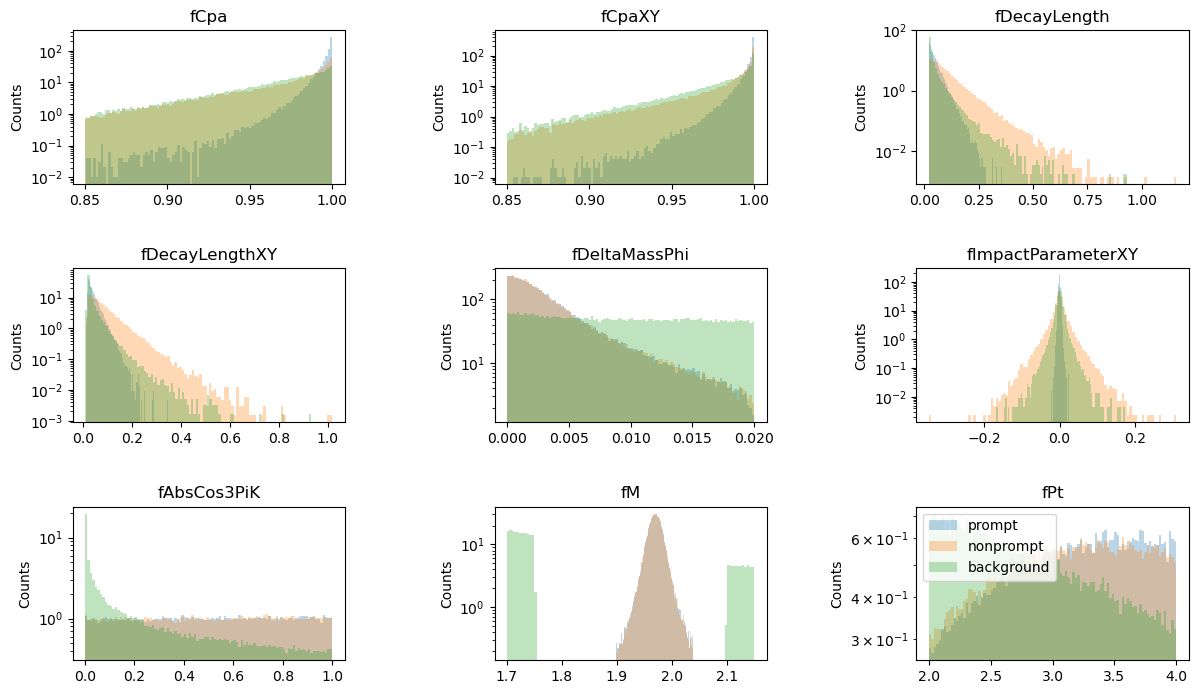

In [12]:
hdl_all = [prompt_data, non_prompt_data, background_data]
vars_to_draw = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 
                'fDeltaMassPhi', 'fImpactParameterXY', 'fAbsCos3PiK',
                 'fM', 'fPt'] ##just a selection of all the possible variables
leg_labels = ["prompt", "nonprompt", "background"] ## matching the order of the hdl_all

plot_utils.plot_distr(hdl_all, vars_to_draw, bins=100, labels=leg_labels, log=True, density=True, figsize=(12, 7), alpha=0.3, grid=False)
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
plt.show()

**Non usiamo massa e pt per l'allenamento: per il pt vogliamo poter vedere come evolte lo spettro del pt quindi sarebbe vincolante, per la massa non vogliamo che la rete dica "ah ok questa è la massa"**

**Q**: Do the distributions look good? 

**Q**: Which features do you expect to have a larger impact on the BDT score?

**A**: AbsCos3PiK and DeltaMassPhi hanno una differenza di forma fra background  e il resto

Similarly, the correlation matrix for the features is plotted with the function `plt_utils.plot_corr`.

It is important cross-check that none of the features is strongly related to the invariant mass to avoid biasing the measurement!

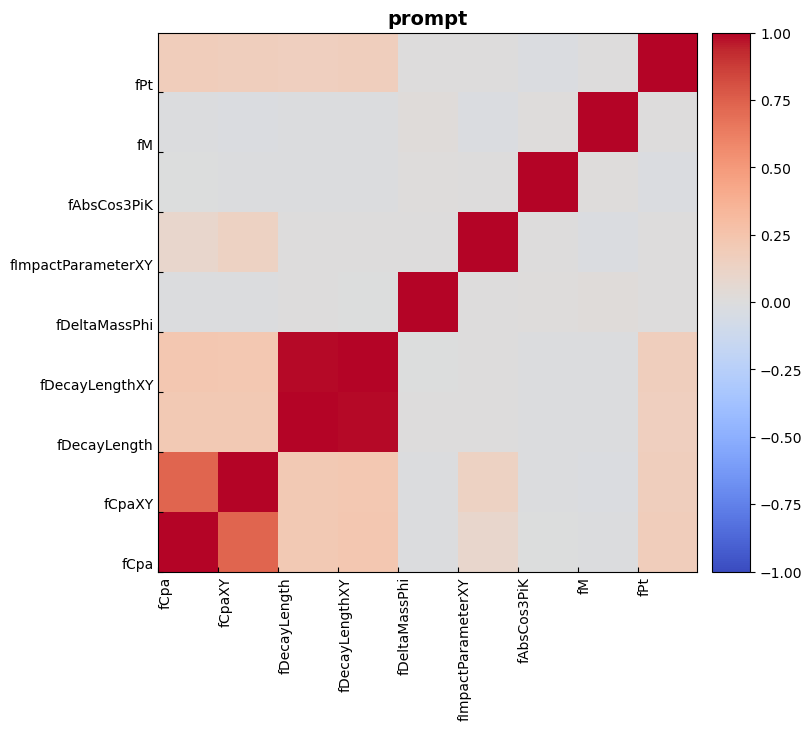

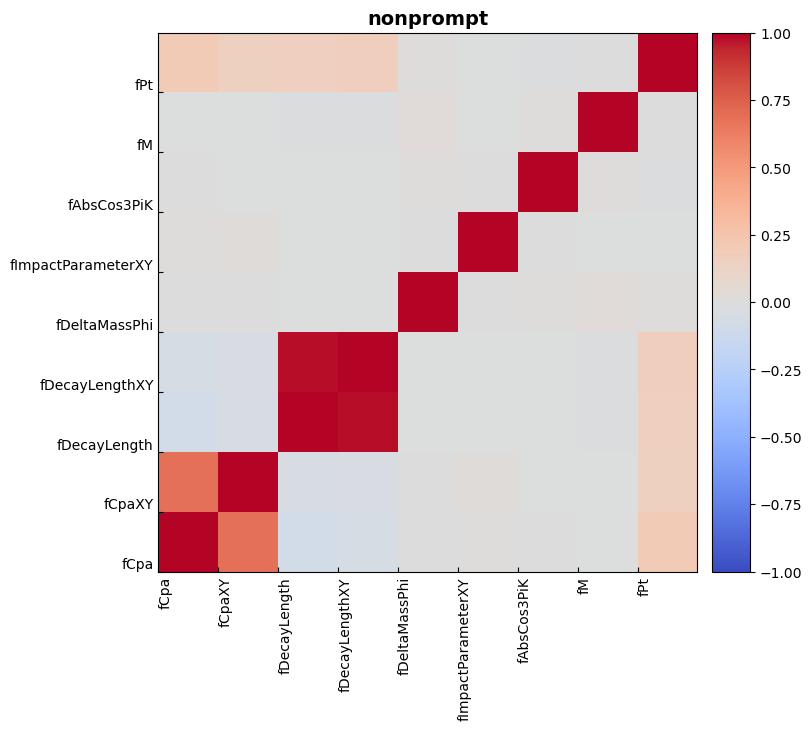

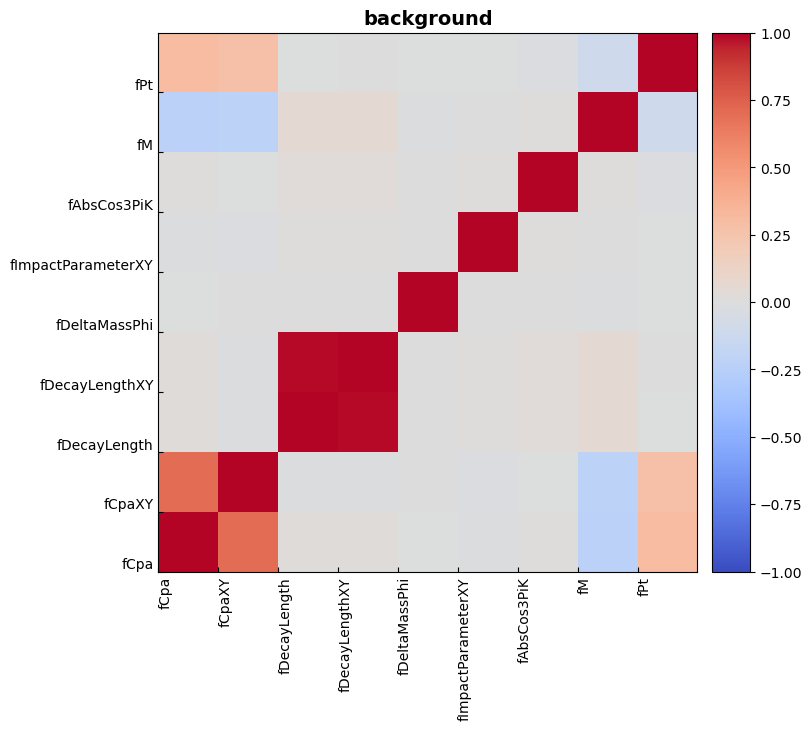

In [13]:
plot_utils.plot_corr(hdl_all, vars_to_draw, leg_labels)
plt.show()

Non vogliamo allenare su Massa e Pt, quindi anche variabili molto correlate non andrebbero bene!

In [14]:
# Combine handlers and select features
hdl_all = [prompt_data, non_prompt_data, background_data]
vars_to_draw = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 
                'fDeltaMassPhi', 'fImpactParameterXY', 'fAbsCos3PiK']  # Selected features
leg_labels = ["prompt", "nonprompt", "background"]  # Matching the order of the handlers

In [15]:
# Convert TreeHandler to pandas DataFrame
prompt_df = prompt_data.get_data_frame()[vars_to_draw]
non_prompt_df = non_prompt_data.get_data_frame()[vars_to_draw]
background_df = background_data.get_data_frame()[vars_to_draw]

A label is assigned to each candidate of the total set: _0_ for prompt $\mathrm{D_s^+}$, _1_ for non-prompt $\mathrm{D_s^+}$, and _2_ for background.

It is important to keep the same order in which the samples are considered also for the labels.

In [16]:
# Add labels: 0 for prompt, 1 for non-prompt, 2 for background
prompt_df['target'] = 0
non_prompt_df['target'] = 1
background_df['target'] = 2

In [17]:
# Combine datasets
data = pd.concat([prompt_df, non_prompt_df, background_df], ignore_index=True)


In [18]:
# Split features and target
target_column = 'target'
X = data[vars_to_draw]
y = data[target_column]


**Standardization of the Features**

Standardization is a preprocessing step in which the features of your dataset are scaled so that they have:
1. A mean of 0.
2. A standard deviation of 1.
This process centers the data around 0 and ensures all features have a similar scale, making them comparable.

The `StandardScaler()` is a class from the sklearn.preprocessing module that compute the mean and standard deviation for each feature in the dataset and then proceed to scale them.


**Why are we scaling our feature?**

Becouse many machine learning algorithms (e.g., neural networks, SVMs) perform better when the input features are scaled to a similar range. 
This avoids one feature dominating others simply because of its larger scale. Furthermore Gradient-based optimizers converge faster when the features are standardized because the loss surface becomes smoother.

In [19]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In order to train and test the NN, the dataset is split into a _train set_ and a _test set_. The train set is used to train the NN, while the test set is used to evaluate the performance of the trained NN. It is important to have independent samples for training and testing to avoid biasing the evaluation of the NN performance.

The fraction of the total set used as test set can be defined through the `test_size` parameter of the function `train_test_split` and is typically around 0.2 (20%). 
Let's split the training set, the test set, and the relative flags. 

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Since we're using PyTorch, we need to convert our data in PyTorch datasets. This is done with the `CostumDataset()` class.

In [21]:
# Convert to PyTorch datasets
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

### **The model**
NN have a flexible architecture, since we can adjust the number of layer and the neuron for layer. Here we have defined a simple NN with only 1 hidden layer, so we have an input layer that have the dimenson of our number of feature, that connect to a layer of 16 neuron in the hidden layer. The output layer only have a number of neuron that corrisponds to our number of classes to be recognized by the NN

In [22]:
class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NeuralNetworkClassificationModel,self).__init__()
        self.input_layer    = nn.Linear(input_dim,16)
        self.hidden_layer1  = nn.Linear(16,16)
        self.output_layer   = nn.Linear(16,output_dim)
        self.relu = nn.ReLU()
    
    
    def forward(self,x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.output_layer(out)
        return out

In [23]:
input_size = len(vars_to_draw)
num_classes = len(np.unique(y))
model = NeuralNetworkClassificationModel(input_size, num_classes)

While trainging a NN, we have 2 _hyperparameters_: the `learing_rate` and the `batch_size`

The first one is the learing rate of the algoritm and controls the step size of the gradient decendent algorithm.

The second one rapresent the number of data that the model elaborate in one iteration of training. This can help particolary when the dataset need to much memory to fit in the RAM of the machine, but can olso help with performance and stability of the optimization.

However, for this first part, we decide to not use the batch size and let the NN operate elaborating all of the dataset at each iteration. This type of approch is call **Bach Gradient Decendent**. Using the BGD approch, we need to update the weights of the NN only one time for epoch (with only one back propagation of the output for iteration).

The BGD approch evalue the gradient more precisely, but can cause problem with large dataset. Since this is not our case, we're good to start with this.

Later we will return on the batch size in order to try to optimize our _hyperparamiters_

In [24]:
# creating our optimizer and loss function object
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

### **Training and testing the model**
The model training is performed with the `traing_network` function. 

During the training we evaluate both the loss function of the training set and the one of the testing set, in order to controll the stability of the learing!

In [25]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)
        


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()

        
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

In [26]:
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

In [27]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)
train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 0.6453, Test Loss: 0.6434
Epoch 100/1000, Train Loss: 0.6121, Test Loss: 0.6123
Epoch 150/1000, Train Loss: 0.5966, Test Loss: 0.5979
Epoch 200/1000, Train Loss: 0.5910, Test Loss: 0.5926
Epoch 250/1000, Train Loss: 0.5876, Test Loss: 0.5891
Epoch 300/1000, Train Loss: 0.5856, Test Loss: 0.5866
Epoch 350/1000, Train Loss: 0.5842, Test Loss: 0.5852
Epoch 400/1000, Train Loss: 0.5834, Test Loss: 0.5844
Epoch 450/1000, Train Loss: 0.5827, Test Loss: 0.5839
Epoch 500/1000, Train Loss: 0.5824, Test Loss: 0.5839
Epoch 550/1000, Train Loss: 0.5819, Test Loss: 0.5833
Epoch 600/1000, Train Loss: 0.5811, Test Loss: 0.5827
Epoch 650/1000, Train Loss: 0.5807, Test Loss: 0.5825
Epoch 700/1000, Train Loss: 0.5801, Test Loss: 0.5821
Epoch 750/1000, Train Loss: 0.5800, Test Loss: 0.5819
Epoch 800/1000, Train Loss: 0.5796, Test Loss: 0.5816
Epoch 850/1000, Train Loss: 0.5795, Test Loss: 0.5815
Epoch 900/1000, Train Loss: 0.5797, Test Loss: 0.5817
Epoch 950/1000, Train Loss: 0

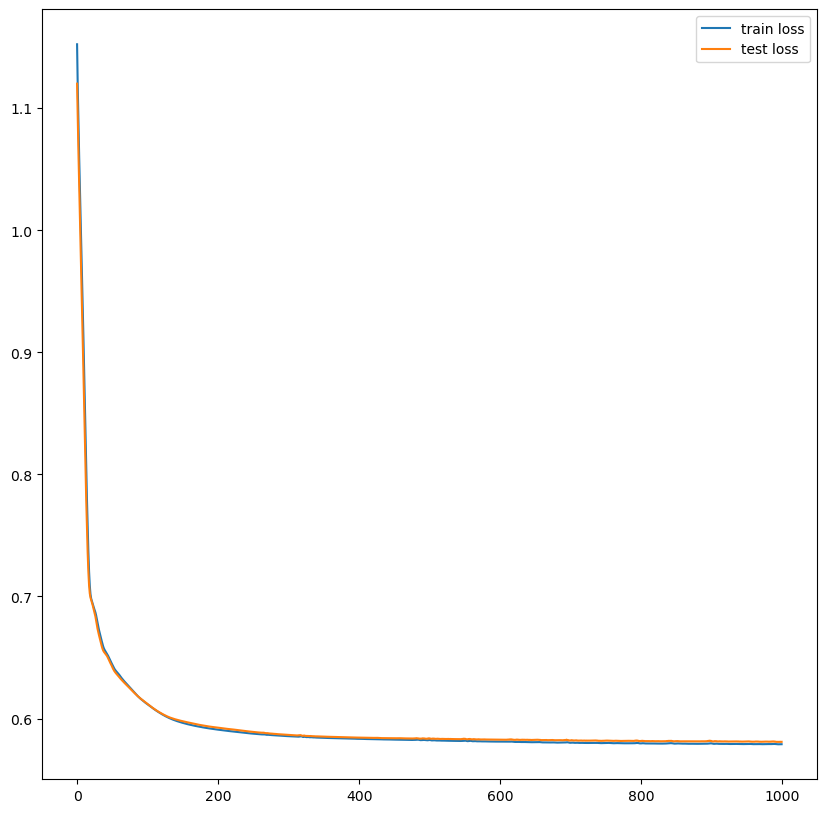

In [28]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

As we can see in this graph, we reach a point of stability in our learing after ~200 iteration

Now we want to see how our model perform!

In [29]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

For now, we will use a common multiclass accuracy for a first numerical indication of the performace of the NN.

In a later part of this notebook we will evaluate the performance using the ROC Curve and the ROC_AUC valute, but for now we simply define our accuracy, as generic as possibile, as the fraction of correct prediction:

$\text{accuracy}=\frac{\text{Total number of correct prediction}}{\text{Total number of element}}$

In [30]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []
    # we will get something like this in the pred_arr [32.1680,12.9350,-58.4877]
    # so will be taking the index of that argument which has the highest value here 32.1680 which corresponds to 0th index
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    #here we are doing a simple comparison between the predicted_arr and the original_arr to get the final accuracy
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

In [31]:
train_acc = get_accuracy_multiclass(predictions_train,y_train)
test_acc  = get_accuracy_multiclass(predictions_test,y_test)

In [32]:
print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 76.253
Test Accuracy: 76.178


The results of the training process can be observed by plotting the distributions of the NN scores for the training and the test sets. The output consists of three scores, related to the probability of belonging to each of the classes (prompt, non-prompt, and background) used for the training. 

The NN doesn't perform this operation out of the box, so we first need to define our probabilities with the `get_scores()` method.

In [44]:
# Funzione per ottenere gli score del modello
def get_scores(model, X, y):
    model.eval()  # Mettiamo il modello in modalità valutazione
    with torch.no_grad():  # Disattiviamo il calcolo del gradiente
        outputs = model(X)  # Calcoliamo gli output
        probabilities = torch.softmax(outputs, dim=1).numpy()  # Convertiamo in probabilità
    return probabilities, y.numpy()  # Restituiamo le probabilità e i target come array numpy


We need to create our dataframe for storing this information and then we can plot our value

In [46]:

# Otteniamo gli score per training e test
prob_train, y_train_np = get_scores(model, X_train, y_train)
prob_test, y_test_np = get_scores(model, X_test, y_test)

# Creiamo DataFrame per training e test
df_train = pd.DataFrame(prob_train, columns=['prompt_score', 'nonprompt_score', 'background_score'])
df_train['label'] = y_train_np

df_test = pd.DataFrame(prob_test, columns=['prompt_score', 'nonprompt_score', 'background_score'])
df_test['label'] = y_test_np

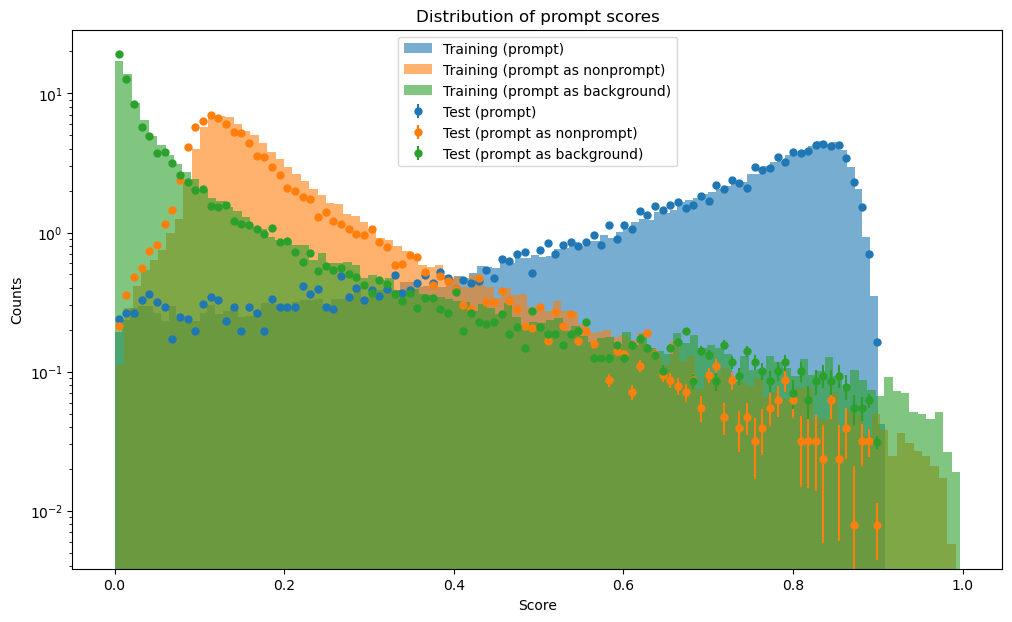

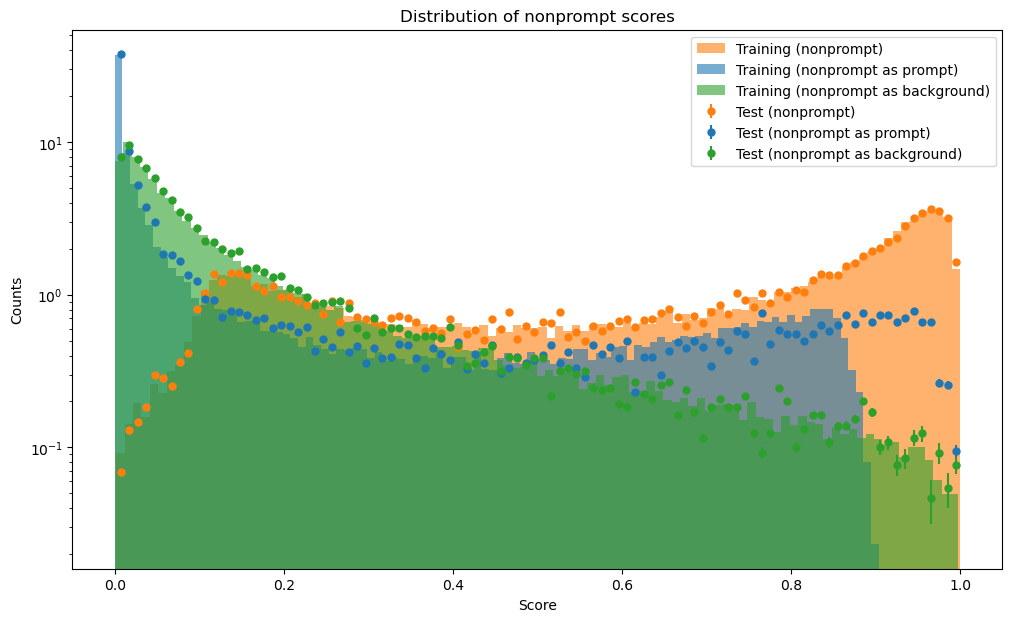

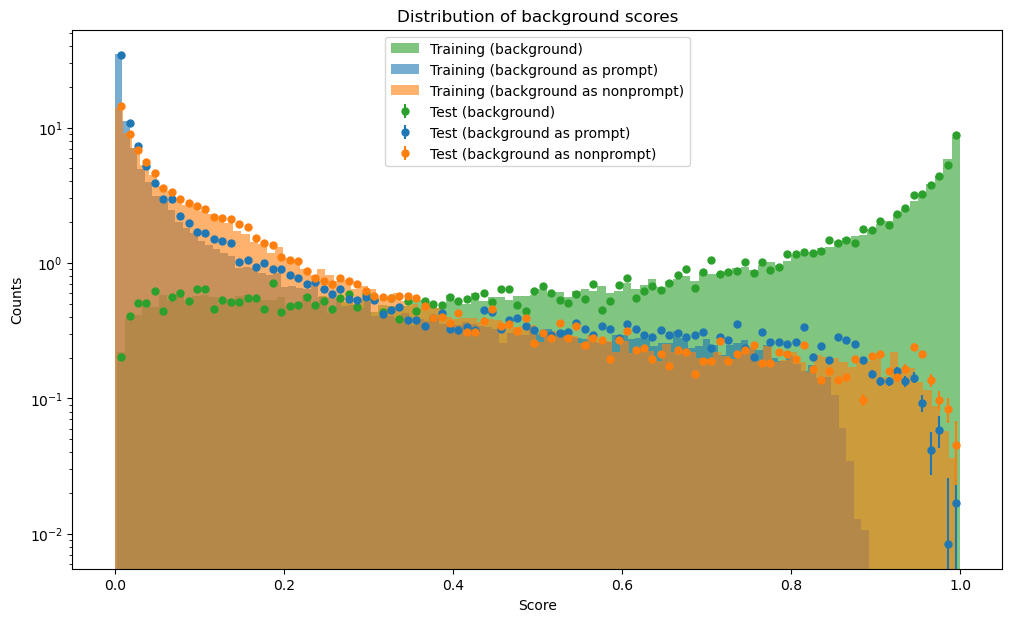

In [47]:
# Classe per cui calcolare la distribuzione
class_labels = ['prompt', 'nonprompt', 'background']
cmap = plt.get_cmap('tab10')
colors = {'prompt':cmap(0), 'nonprompt': cmap(1), 'background': cmap(2)}
# Creiamo i plot
for i, class_label in enumerate(class_labels):
    plt.figure(figsize=(12, 7))
    
    # Training set: Istogramma
    df_train[df_train['label'] == i][f'{class_label}_score'].plot(
        kind='hist', bins=100, alpha=0.6, log=True, grid=False, color=colors[class_label],
        label=f'Training ({class_label})', density=True
    )
    
    # Test set: Punti con errore
    hist, bins = np.histogram(df_test[df_test['label'] == i][f'{class_label}_score'], bins=100, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Centro dei bin
    bin_width = bins[1] - bins[0]
    bin_errors = np.sqrt(hist) / (len(df_test[df_test['label'] == i]) * bin_width)  # Errore standard
    
    plt.errorbar(bin_centers, hist, yerr=bin_errors, fmt='o', color=colors[class_label], 
                 label=f'Test ({class_label})', markersize=5, linestyle='None')

    # Le probabilità di essere una classe diversa (altre due classi)
    other_classes = [x for x in class_labels if x != class_label]  # Le altre 2 classi

    for j, other_class in enumerate(other_classes):
        # Training set: altre classi
        df_train[df_train['label'] == i][f'{other_class}_score'].plot(
            kind='hist', bins=100, alpha=0.6, log=True, grid=False, 
            label=f'Training ({class_label} as {other_class})', density=True, color=colors[other_class]
        )
        
        # Test set: altre classi (punti con errore)
        hist_other, _ = np.histogram(df_test[df_test['label'] == i][f'{other_class}_score'], bins=100, density=True)
        plt.errorbar(bin_centers, hist_other, yerr=bin_errors, fmt='o', color=colors[other_class], 
                     label=f'Test ({class_label} as {other_class})', markersize=5, linestyle='None')

    plt.title(f'Distribution of {class_label} scores')
    plt.xlabel('Score')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid(False)
    plt.show()


What can we say about the distributions of the NN scores?
- For each class, the distribution of the NN scores related to the probability of belonging to that class peaks at high values (i.e., close to 1).
- For each class, the distributions of the NN scores related to the probability of belonging to the other classes peak at low values (i.e., close to 0).
- The distributions of the model scores obtained from the test set are in good agreement with those obtained from the training set. This is a sign that the model is not significantly affected by overfitting.

We have a good performing model!

### **Apply the model on the dataset we want to analyse!**
We have downloaded a file called `data_application.parquet` in the `data` folder. This file contains the dataset we want to analyse. We should now load the file with the `TreeHandler` class and apply the model you have just trained on it.

It's imporant to notice that we need to extract the feature for our model plus the Mass, for studing the invariant mass plot of our reconstructed particle!

In [34]:
# Caricamento dei dati di applicazione
hdl_data_appl = TreeHandler("data/data_application.parquet")
hdl_data_appl.apply_preselections("2 < fPt < 4")

# Estrazione del DataFrame con le feature usate nel training e altre informazioni
vars_to_draw = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 
                'fDeltaMassPhi', 'fImpactParameterXY', 'fAbsCos3PiK', 'fM']  # Aggiungi anche 'fM'
df_appl = hdl_data_appl.get_data_frame()[vars_to_draw]

Since we want to study the distribution of the mass, we need to extract the Mass value and not standardize it

In [35]:
# Separazione della massa (non va standardizzata)
fM_values = df_appl['fM'].copy()

# Standardizzazione delle feature (usando lo stesso scaler del training)
X_appl = scaler.transform(df_appl.drop(columns=['fM']))  # Escludi la massa dalla standardizzazione


We can now use the model in evaluate mode on our data

In [36]:
# Predizioni del modello sui dati di applicazione
model.eval()
with torch.no_grad():
    X_tensor_appl = torch.tensor(X_appl, dtype=torch.float32)
    outputs_appl = model(X_tensor_appl)

Now, we will add the NN score to the dataset we want to analyse, and plot the NN score distributions for the prompt, non-prompt, and background classes.

In [37]:
# Conversione degli output in probabilità
probabilities = torch.softmax(outputs_appl, dim=1).numpy()

# Aggiunta delle probabilità al DataFrame
df_appl['prompt_score'] = probabilities[:, 0]  # Classe "prompt"
df_appl['nonprompt_score'] = probabilities[:, 1]  # Classe "non-prompt"
df_appl['background_score'] = probabilities[:, 2]  # Classe "background"

# Riaggiungi i valori della massa al DataFrame (separata in precedenza)
df_appl['fM'] = fM_values

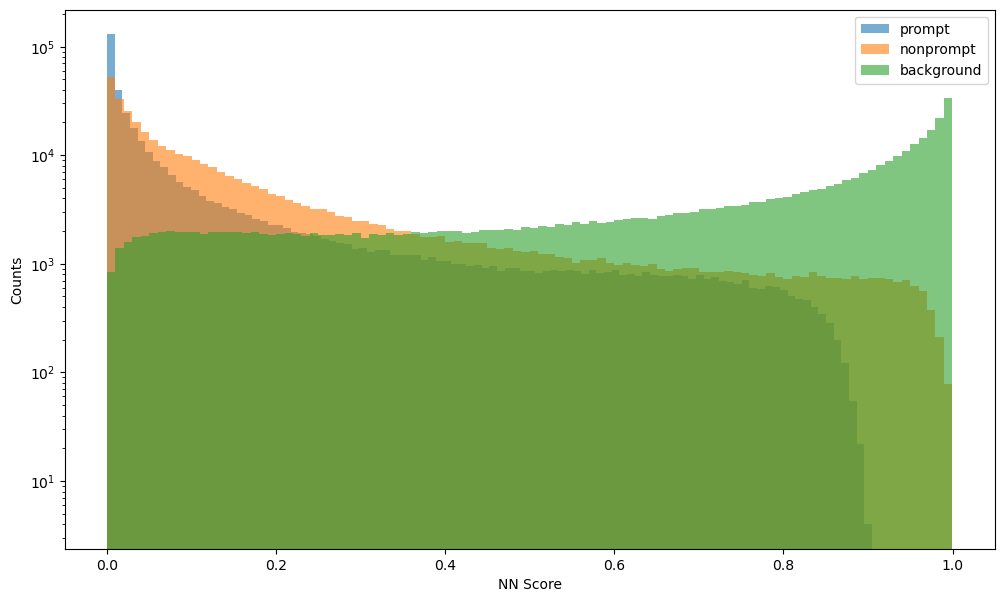

In [38]:
# Plot degli score per le tre classi
plt.figure(figsize=(12, 7))
df_appl['prompt_score'].plot(kind='hist', bins=100, alpha=0.6, log=True, grid=False, label='prompt')
df_appl['nonprompt_score'].plot(kind='hist', bins=100, alpha=0.6, log=True, grid=False, label='nonprompt')
df_appl['background_score'].plot(kind='hist', bins=100, alpha=0.6, log=True, grid=False, label='background')
plt.xlabel('NN Score')
plt.ylabel('Counts')
plt.legend()
plt.show()

What can we see?

The NN score distributions for the prompt and non-prompt classes peak at low values, while the NN score distribution for the background class peaks at high values. We are therefore in presence of a data sample with a lot of background candidates.

(You should consider that this plot shows the distributions of the probabilities of the candidates to belong to the prompt, non-prompt, and background classes, for a **single** dataset. It is different from the similar plot we made before, which showed the distributions of the probabilities of candidates from the **three classes** to belong to **a single** class.)

### **Choose your selections!**
Almost there! We can now apply some selections to the dataset. To do so, we use the `query` method of pandas.DataFrame, which takes as argument a string containing the selection we want to apply.

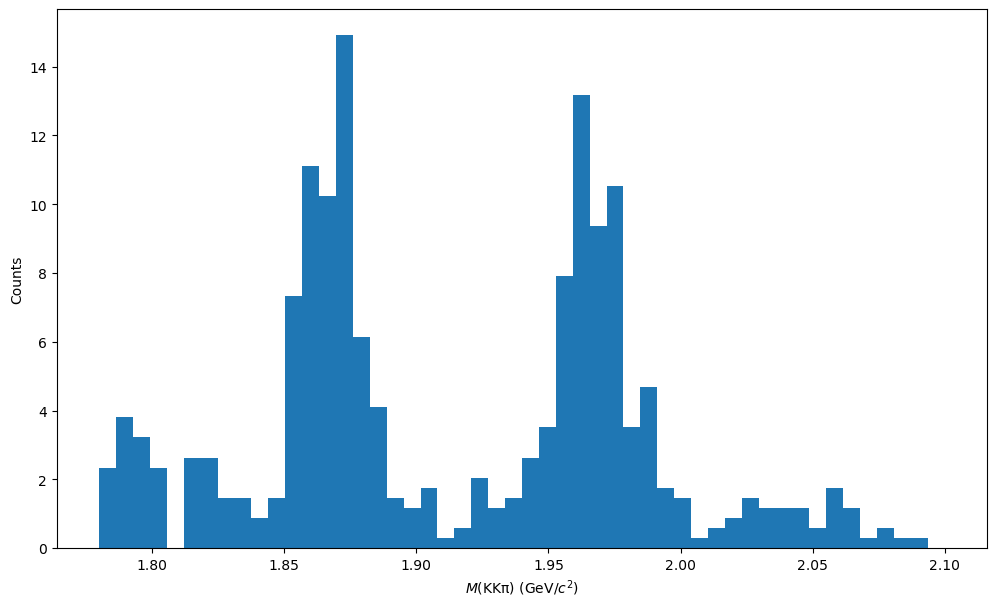

In [39]:
# Selezione degli eventi in base agli score
selections = 'prompt_score > 0.2 and background_score < 0.01'  # Modifica i valori a piacere
df_sel = df_appl.query(selections)

# Plot dell'istogramma della massa ricostruita (fM)
hist = df_sel.hist(column='fM', bins=50, range=(1.78, 2.1), figsize=(12, 7), grid=False, density=True)
plt.xlabel(r'$M(\mathrm{KK\pi})$ (GeV/$c^2$)')
plt.ylabel('Counts')
plt.title('')
plt.show()

Congratulations! We have observed a $\mathrm{D^{+}_{s}}$ meson signal!

We can now understand the reason for such a strange sideband definition: we can also recontruct the $\mathrm{D^{+}\rightarrow \mathrm{\phi} \pi^+ \rightarrow K^+ K^- \pi^-}$ meson signal, which is the peak you can see in the left part of the plot.

### **Efficiency evaluation**
When applying a selection to the dataset, we typically reject a fraction of the signal candidates. Therefore, it is important to evaluate the efficiency of the selection. The efficiency is defined as the fraction of signal candidates that pass the selection.

It is very important, in order not to bias the efficiency evaluation, not to evaluate the efficiency on the same dataset used to train the model. This is because the model has already seen the candidates in the training set and has learned from them. Therefore, the efficiency evaluation should be performed on an independent dataset.

We can use the test set for this purpose. Firstly, we need to convert our data in NumPy array and obtain the prediction of the model.

Then we retrieve the prompt and non-prompt candidates from the test set.

In [40]:
# Convertiamo le variabili di test in NumPy per lavorare con pandas e calcoli successivi
X_test_np = X_test.numpy()  # Convertiamo il tensore in un array NumPy
y_test_np = y_test.numpy()  # Convertiamo il tensore in un array NumPy

# Otteniamo le predizioni del modello
with torch.no_grad():  # Disattiviamo il calcolo dei gradienti per ottimizzare la memoria
    y_pred_test = torch.softmax(model(X_test), dim=1)  # Otteniamo le probabilità predette
y_pred_test_np = y_pred_test.numpy()  # Convertiamo il tensore in NumPy

# Separiamo le caratteristiche (features) in base alle etichette
test_features_prompt = X_test_np[y_test_np == 0]  # Classe "prompt"
test_features_nonprompt = X_test_np[y_test_np == 1]  # Classe "non-prompt"

# Predizioni per ogni classe
test_scores_prompt = y_pred_test_np[y_test_np == 0]  # Predizioni per la classe "prompt"
test_scores_nonprompt = y_pred_test_np[y_test_np == 1]  # Predizioni per la classe "non-prompt"

# Creiamo DataFrame per lavorare con le selezioni
test_features_prompt = pd.DataFrame(test_features_prompt)  # Convertiamo in DataFrame
test_features_nonprompt = pd.DataFrame(test_features_nonprompt)  # Convertiamo in DataFrame

# Aggiungiamo i punteggi predetti come colonne nei DataFrame
test_features_prompt['prompt_score'] = test_scores_prompt[:, 0]  # Classe "prompt"
test_features_prompt['nonprompt_score'] = test_scores_prompt[:, 1]  # Classe "non-prompt"
test_features_prompt['background_score'] = test_scores_prompt[:, 2]  # Classe "background"

test_features_nonprompt['prompt_score'] = test_scores_nonprompt[:, 0]  # Classe "prompt"
test_features_nonprompt['nonprompt_score'] = test_scores_nonprompt[:, 1]  # Classe "non-prompt"
test_features_nonprompt['background_score'] = test_scores_nonprompt[:, 2]  # Classe "background"


Now, we can apply the selection to the test set and evaluate the efficiency.

In [48]:

# Definiamo la selezione (modifica questa logica se necessario)
selections = 'prompt_score > 0.2 and background_score < 0.01'

# Applichiamo la selezione e calcoliamo le efficienze
sel_df_prompt = test_features_prompt.query(selections)
sel_df_nonprompt = test_features_nonprompt.query(selections)

eff_prompt = len(sel_df_prompt) / len(test_features_prompt)
eff_nonprompt = len(sel_df_nonprompt) / len(test_features_nonprompt)

print("Prompt efficiency: ", eff_prompt)
print("Nonprompt efficiency: ", eff_nonprompt)


Prompt efficiency:  0.16551937504834094
Nonprompt efficiency:  0.04780114722753346


We can also study how the efficiency changes with the selection on the prompt NN score. We can plot the efficiency as a function of the NN score.

In [42]:

# Ora calcoliamo l'efficienza in funzione della soglia di score
prompt_scores = np.linspace(0.0, 0.85, 86)  # [0.00, 0.01, ..., 0.85]
efficiencies_prompt = []
efficiencies_nonprompt = []

for score in prompt_scores:
    selections = f'prompt_score > {score} and background_score < 0.05'
    sel_df_prompt = test_features_prompt.query(selections)
    sel_df_nonprompt = test_features_nonprompt.query(selections)
    
    efficiencies_prompt.append(len(sel_df_prompt) / len(test_features_prompt))
    efficiencies_nonprompt.append(len(sel_df_nonprompt) / len(test_features_nonprompt))


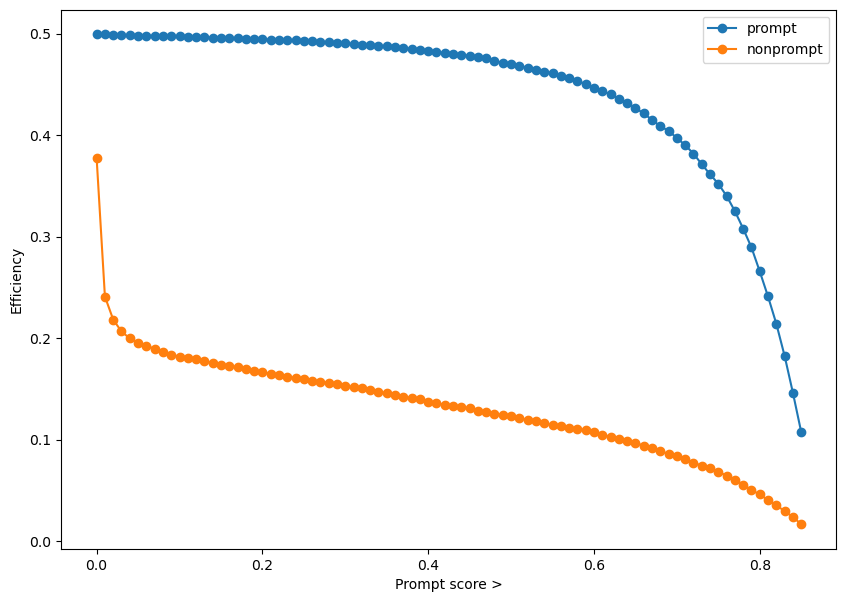

In [43]:

# Visualizziamo le efficienze
plt.plot(prompt_scores, efficiencies_prompt, label='prompt', marker='o')
plt.plot(prompt_scores, efficiencies_nonprompt, label='nonprompt', marker='o')
plt.xlabel('Prompt score >')
plt.ylabel('Efficiency')
plt.legend()
plt.show()


As we can see, the selection on the prompt score does a very good job in rejecting non-prompt candidates. The efficiency is very high for prompt candidates, while it is very low for non-prompt candidates.

At very high threshold values, the efficiency for prompt candidates steeply decreases.

### **Receiver Operating Curve**
The quality of the algorithm can be also studied with the _Receiver Operating Characteristic_ (_ROC_) curve. The ROC curve which represents the true positive rate (TPR) against the false positive rate (FPR) for different thresholds on the BDT ouptut values. TPR and FPR are defined as:

$\mathrm{TPR}=\frac{\sum \mathrm{TP}}{\sum \mathrm{TP} + \sum \mathrm{FN}} \hspace{2cm} \mathrm{FPR}=\frac{\sum \mathrm{FP}}{\sum \mathrm{FP} + \sum \mathrm{TN}} $

The true positives (TP) are the number of correctly classified positive candidates, the false positives (FP) are the number of negative candidates being mistakenly classified as positives, and the true negatives (TN) and false negatives (FN) are defined similarly.

In the case of multi-classifiaction problems, the ROC curve is not natively defined. Hence, we can generalise it by either employing the _One Vs One_ or the _One Vs Rest_ approach. In this tutorial, we adopt the _One Vs One_, which is a plot of the TPR against the FPR for a given pair of classes. For a classification problem with $N$ classes, there are $N(N − 1)$ possible pairs of ordered classes, and therefore of _One Vs One_ ROC curves.

A common way employed to evaluate the performance of a NN is to compute the _Area Under the Curve_ ROC, called AUC. The ROC AUC ranges from 0 to 1. A random classifier has a ROC AUC of 0.5, while a perfect classifier has a ROC AUC of 1.

A good model classifier is characterised by a large area under the ROC curve (_ROC AUC_).

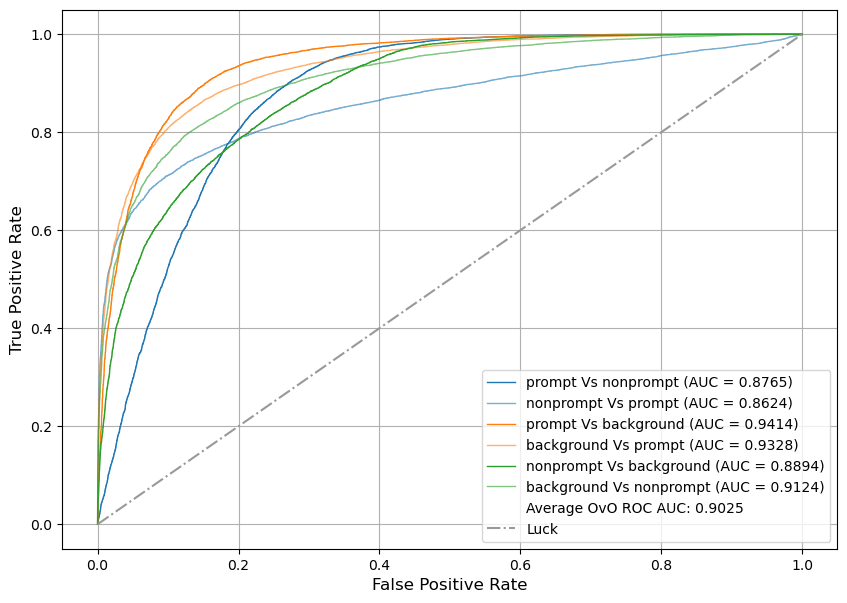

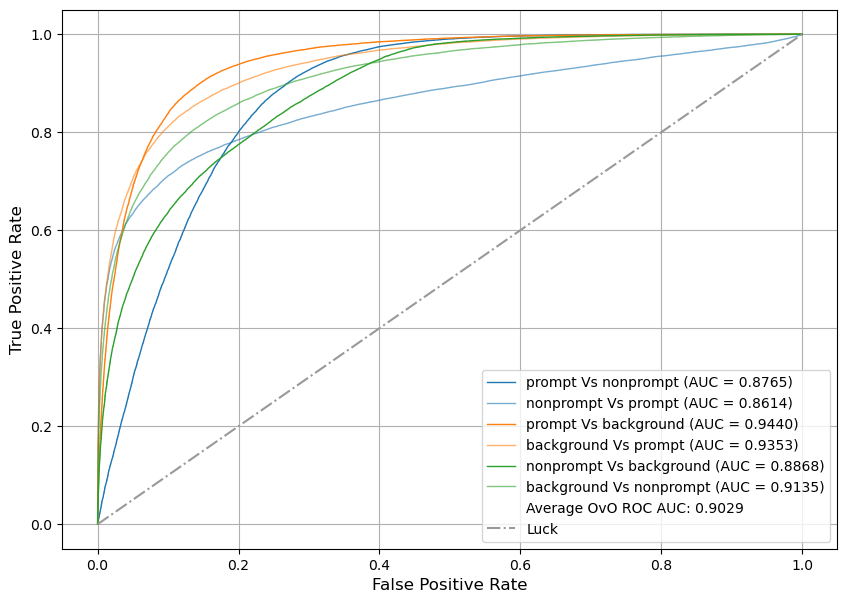

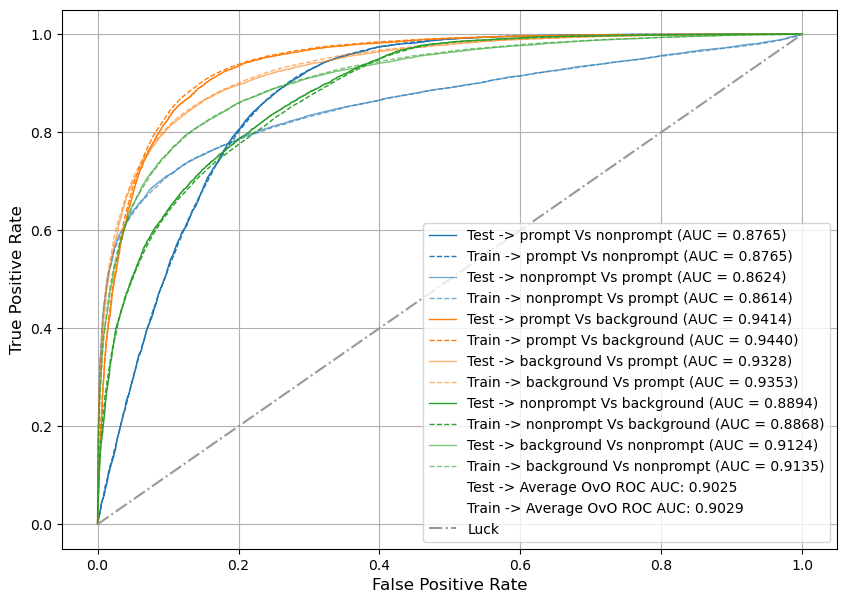

In [52]:
X_test_np = X_test.numpy()  # Convertiamo il tensore in un array NumPy
y_test_np = y_test.numpy()
X_train_np = X_train.numpy()  # Convertiamo il tensore in un array NumPy
y_train_np = y_train.numpy()
# Otteniamo le predizioni del modello
with torch.no_grad():  # Disattiviamo il calcolo dei gradienti per ottimizzare la memoria
    y_pred_test = torch.softmax(model(X_test), dim=1)  # Otteniamo le probabilità predette
    y_pred_train = torch.softmax(model(X_train), dim=1)
y_pred_test_np = y_pred_test.numpy()
y_pred_train_np = y_pred_train.numpy()

# this will produce 3 plots: the ROC curves for the training and test sets, and the a comparison of the two
roc_train_test_fig = plot_utils.plot_roc_train_test(y_test_np, y_pred_test_np, y_train_np, y_pred_train_np, None, leg_labels, multi_class_opt="ovo")

plt.show()

### **Optimization of hyperparameters and architecture of the NN** 
For exploring the performance of our NN, we need to change a little our model so that we can set different architecture of the model and introduct our second hyperpparamiter: the batch size

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd


In [54]:
# Funzione per esplorare l'architettura della rete
class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        super(NeuralNetworkClassificationModel, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        self.layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(hidden_layers[-1], output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [55]:
# Dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [56]:
# Funzione per il training

def train_network(model, optimizer, criterion, train_loader, test_loader, num_epochs):
    train_losses, test_losses = [], []
    model.train()

    for epoch in range(num_epochs):
        epoch_train_loss = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss
        model.eval()
        epoch_test_loss = 0

        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                epoch_test_loss += loss.item()

        test_losses.append(epoch_test_loss / len(test_loader))

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

Then we want to prepare our data for a first explorative (and not so efficient) analisis of the parameters and the architecture of the NN. We will test the performance of the NN using the roc_auc_ovo metric in the different configuration

In [90]:
# Caricamento dei dati puliti per ottimizzare la struttura della rete e gli iperparametri
vars_to_draw = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 
                'fDeltaMassPhi', 'fImpactParameterXY', 'fAbsCos3PiK']

#`X` and `y` are already pre-processed
target_column = 'target'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Spazio delle configurazioni da testare nell'ottimizzazione
hidden_layer_configs = [[4,4], [8, 8], [16, 16], [4, 4, 4], [8, 8, 8], [16, 16, 16] ]
learning_rates = [0.005, 0.01, 0.02, 0.03, 0.04]
batch_sizes = [64, 128, 256, 512, 1024]

best_model = None
best_auc = 0

This operation is kinda rudimental, using a grid to test the performance in evry combination of our given paramiters

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Funzione per calcolare la media del ROC-AUC OVO
def calculate_mean_roc_auc_ovo(model, data_loader, y_true, num_classes):
    model.eval()
    y_scores = []
    with torch.no_grad():
        for features, _ in data_loader:
            outputs = model(features)
            probabilities = torch.softmax(outputs, dim=1)
            y_scores.extend(probabilities.numpy())

    y_scores = np.array(y_scores)
    y_true = np.array(y_true)
    return roc_auc_score(y_true, y_scores, multi_class="ovo")

# Per memorizzare i risultati
results = []

for hidden_layers in hidden_layer_configs:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training with hidden_layers={hidden_layers}, lr={lr}, batch_size={batch_size}")

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            model = NeuralNetworkClassificationModel(len(vars_to_draw), len(np.unique(y)), hidden_layers)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            train_losses, test_losses = train_network(
                model, optimizer, criterion, train_loader, test_loader, num_epochs=100
            )

            # Calcolo AUC medio su test set
            y_true_test = y_test
            test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
            mean_roc_auc_ovo = calculate_mean_roc_auc_ovo(model, test_loader, y_true_test, len(np.unique(y)))

            # Memorizziamo i risultati
            results.append({
                "hidden_layers": hidden_layers,
                "lr": lr,
                "batch_size": batch_size,
                "mean_roc_auc_ovo": mean_roc_auc_ovo
            })


Training with hidden_layers=[4, 4], lr=0.005, batch_size=64
Epoch 50/100, Train Loss: 0.6092, Test Loss: 0.6115
Epoch 100/100, Train Loss: 0.6090, Test Loss: 0.6141
Training with hidden_layers=[4, 4], lr=0.005, batch_size=128
Epoch 50/100, Train Loss: 0.6138, Test Loss: 0.6155
Epoch 100/100, Train Loss: 0.6138, Test Loss: 0.6143
Training with hidden_layers=[4, 4], lr=0.005, batch_size=256
Epoch 50/100, Train Loss: 0.6091, Test Loss: 0.6117
Epoch 100/100, Train Loss: 0.6084, Test Loss: 0.6109
Training with hidden_layers=[4, 4], lr=0.005, batch_size=512
Epoch 50/100, Train Loss: 0.6100, Test Loss: 0.6110
Epoch 100/100, Train Loss: 0.6100, Test Loss: 0.6103
Training with hidden_layers=[4, 4], lr=0.005, batch_size=1024
Epoch 50/100, Train Loss: 0.6126, Test Loss: 0.6176
Epoch 100/100, Train Loss: 0.6120, Test Loss: 0.6151
Training with hidden_layers=[4, 4], lr=0.01, batch_size=64
Epoch 50/100, Train Loss: 0.6156, Test Loss: 0.6158
Epoch 100/100, Train Loss: 0.6150, Test Loss: 0.6186
Traini

We than want to find the best configuration fond with our paramiters

In [94]:
# Identificazione della configurazione con il massimo ROC-AUC
best_result = max(results, key=lambda x: x["mean_roc_auc_ovo"])

# Stampa della configurazione migliore
print("\nBest configuration:")
print(f"  Mean ROC-AUC OVO: {best_result['mean_roc_auc_ovo']:.4f}")
print(f"  Hidden Layers: {best_result['hidden_layers']}")
print(f"  Learning Rate: {best_result['lr']:.5f}")
print(f"  Batch Size: {best_result['batch_size']}")


Best configuration:
  Mean ROC-AUC OVO: 0.9028
  Hidden Layers: [16, 16]
  Learning Rate: 0.00500
  Batch Size: 512


It's olso intresting to visualize the contour plot of evry achitecture to have a look on the differnt performance with the combination of learing rate and batch size

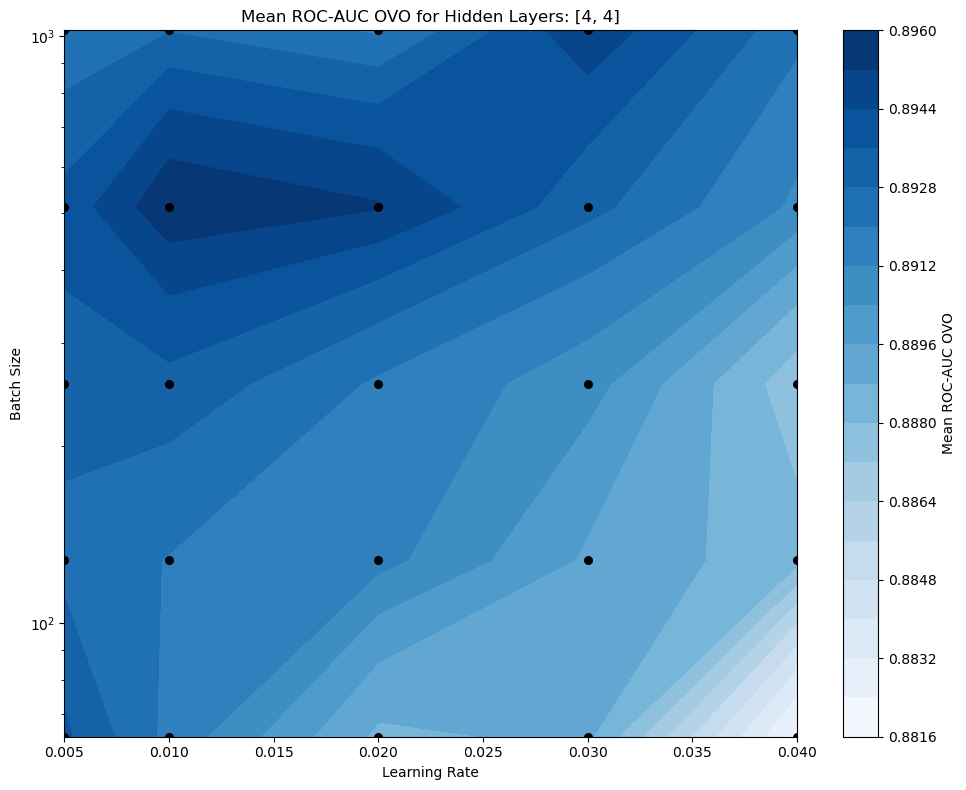

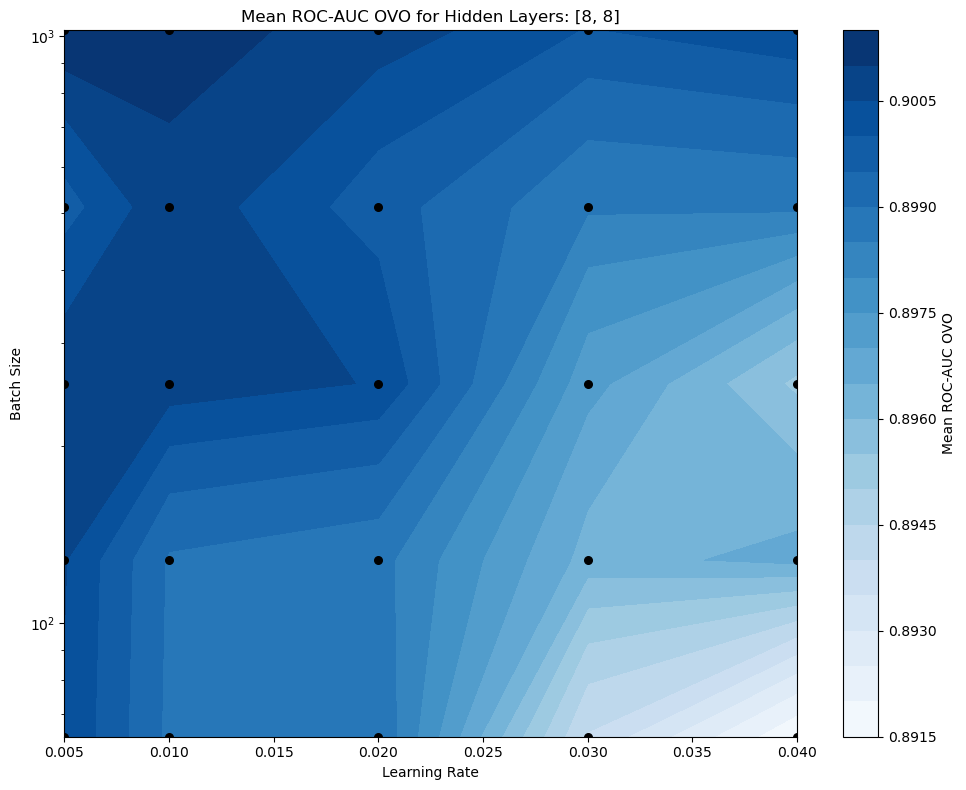

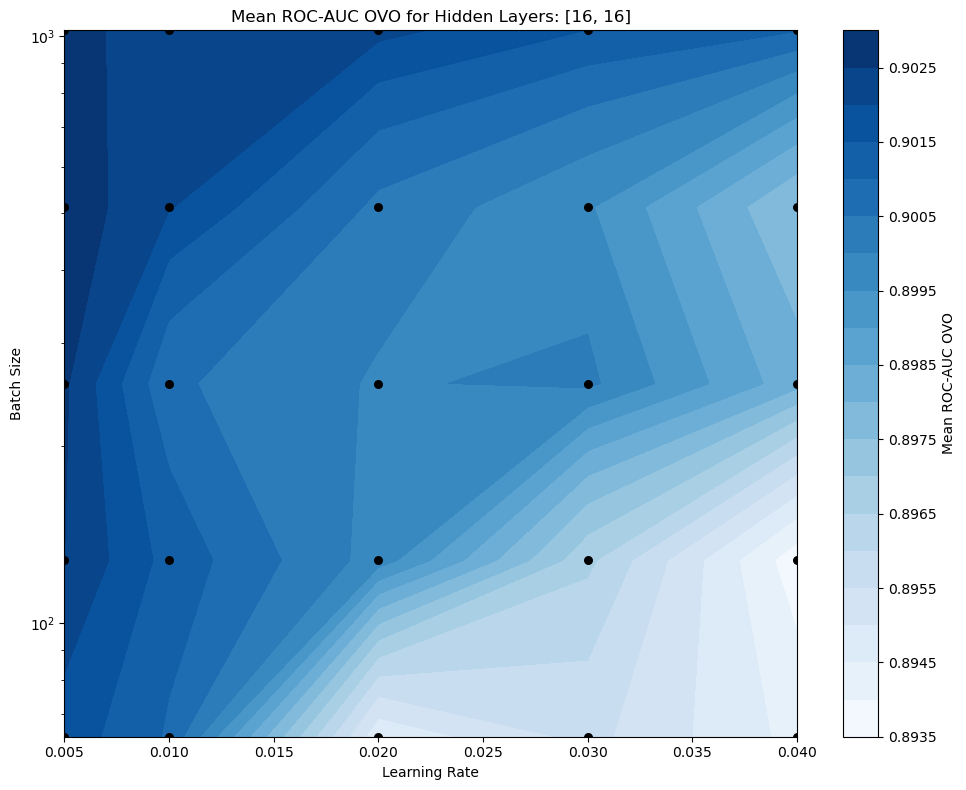

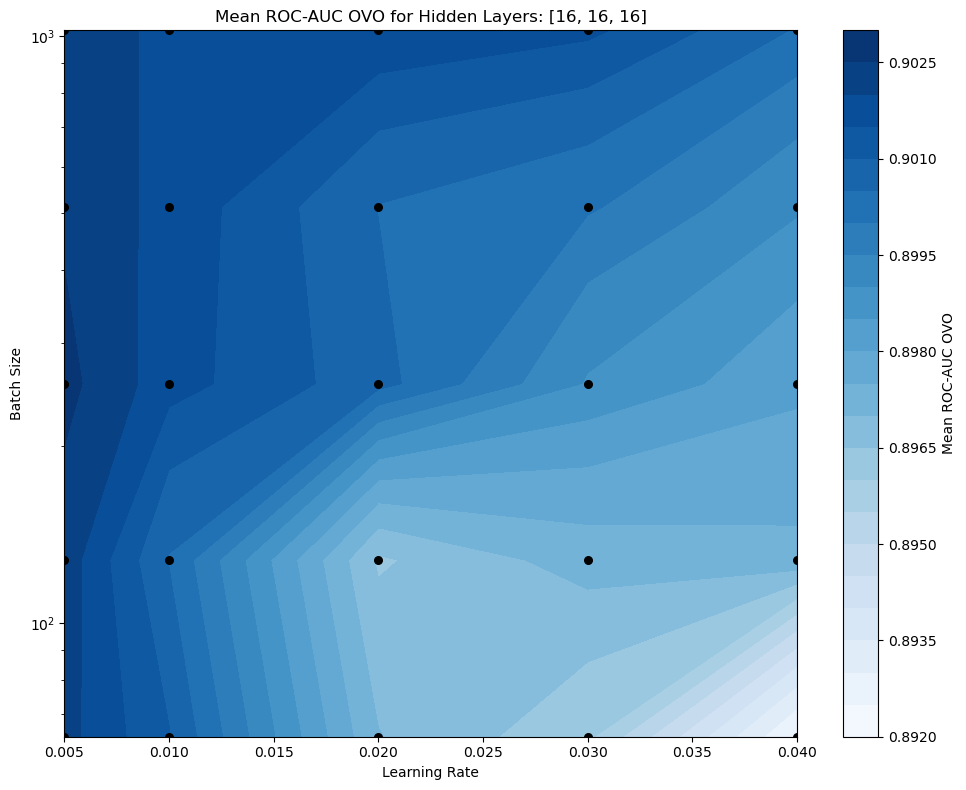

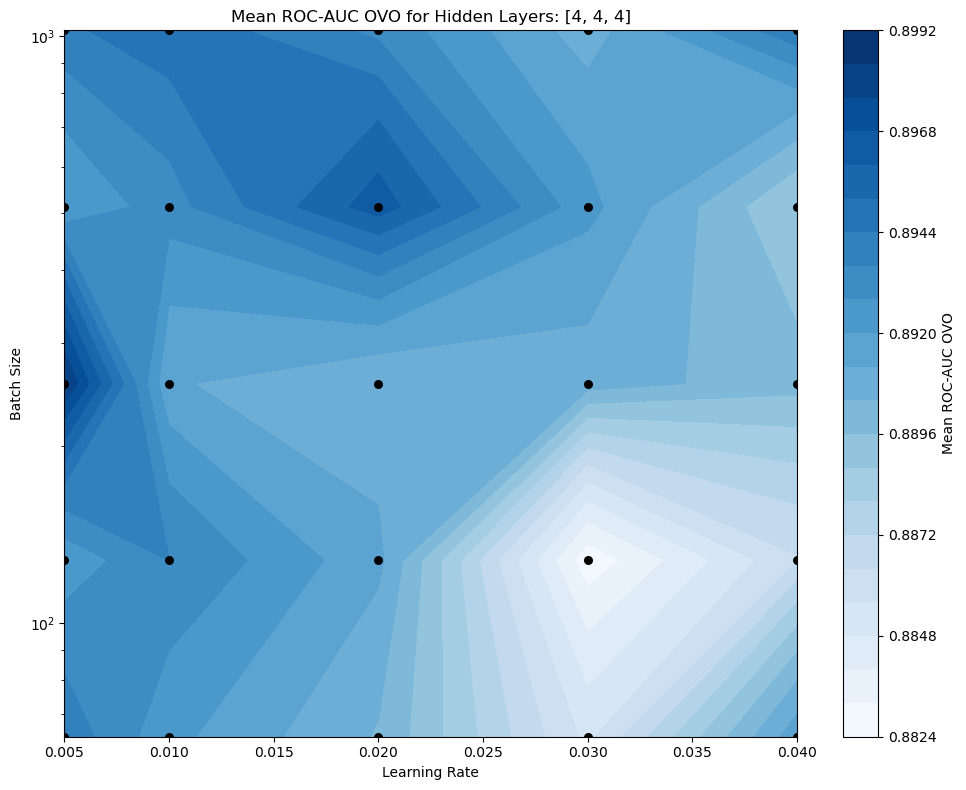

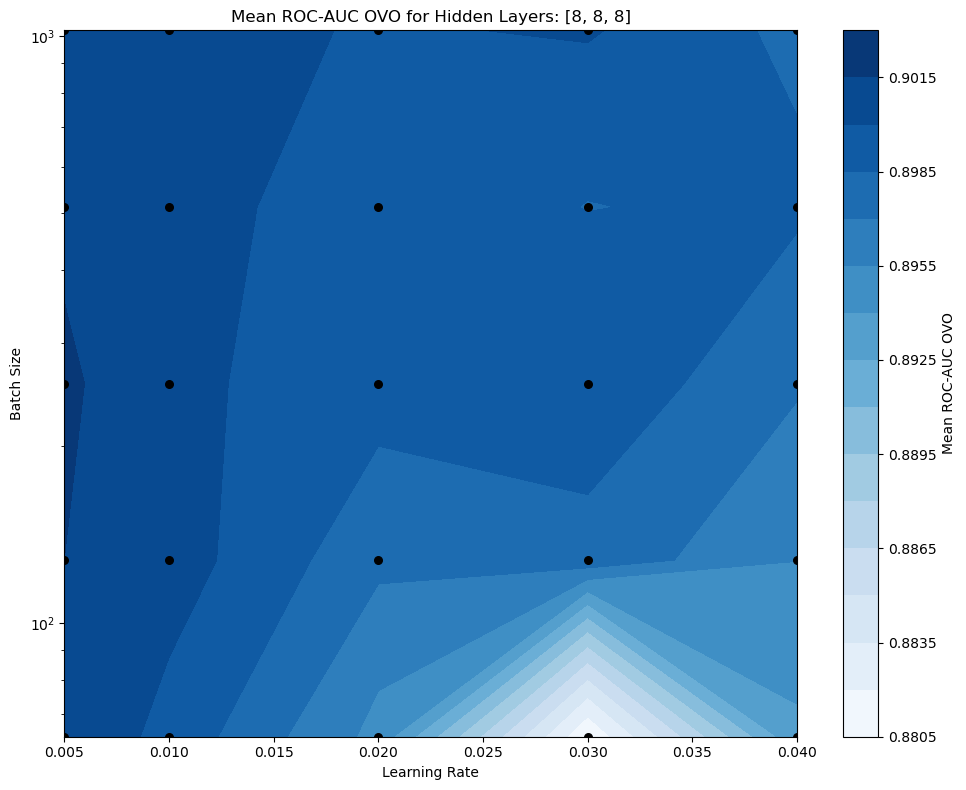

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Creazione dei plot 2D
hidden_layer_configs = list(set(tuple(res["hidden_layers"]) for res in results))
for hidden_layers in hidden_layer_configs:
    # Filtriamo i risultati per la configurazione attuale
    hidden_layers = list(hidden_layers)
    filtered_results = [res for res in results if res["hidden_layers"] == hidden_layers]

    # Creiamo una griglia con lr e batch_size
    lrs = list(set([res["lr"] for res in filtered_results]))
    batch_sizes = list(set([res["batch_size"] for res in filtered_results]))
    lrs.sort()
    batch_sizes.sort()

    heatmap = np.zeros((len(batch_sizes), len(lrs)))
    for res in filtered_results:
        lr_idx = lrs.index(res["lr"])
        batch_size_idx = batch_sizes.index(res["batch_size"])
        heatmap[batch_size_idx, lr_idx] = res["mean_roc_auc_ovo"]

    # Calcolo dei margini
    lr_margin = 0.1 * (max(lrs) - min(lrs))  # 10% del range dei learning rate
    batch_size_margin = 0.1 * (max(batch_sizes) - min(batch_sizes))  # 10% del range dei batch size

    # Creazione del contour plot
    plt.figure(figsize=(10, 8))
    lr_grid, batch_size_grid = np.meshgrid(lrs, batch_sizes)
    contour = plt.contourf(
        lr_grid, batch_size_grid, heatmap, levels=20, cmap="Blues"
    )
    plt.colorbar(contour, label="Mean ROC-AUC OVO")

    # Aggiunta dei pallini neri nei punti calcolati
    for res in filtered_results:
        plt.scatter(res["lr"], res["batch_size"], color="black", label="Data Points", s=30)



    plt.xlabel("Learning Rate")
    plt.ylabel("Batch Size")
    plt.title(f"Mean ROC-AUC OVO for Hidden Layers: {hidden_layers}")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()


With a box plot we can also look at the general performance of our architecture

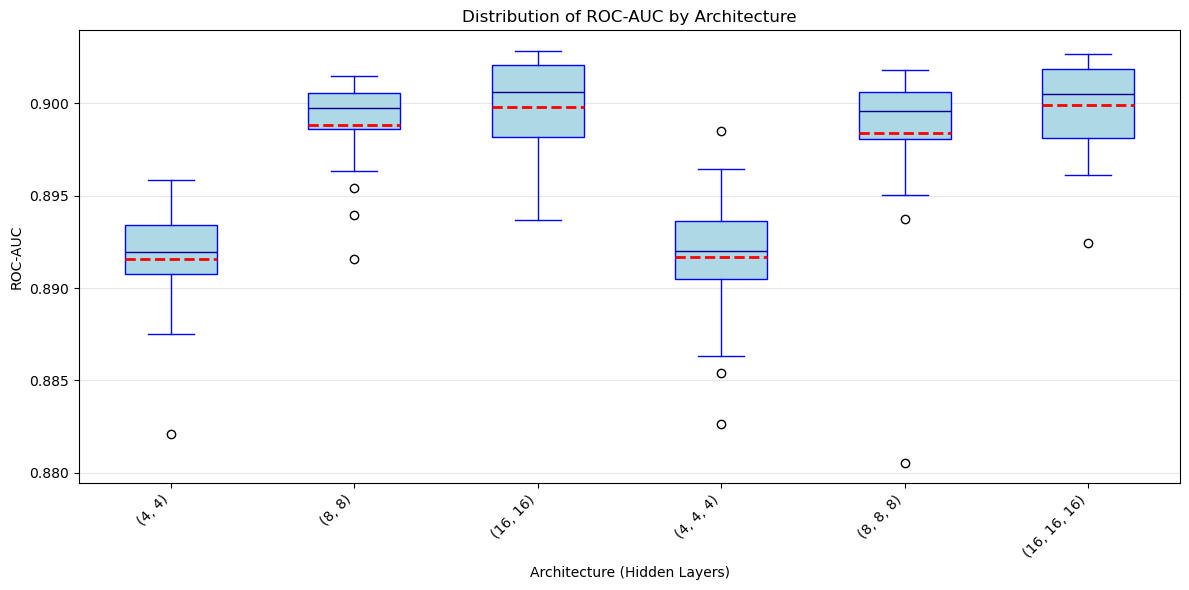

In [98]:
import matplotlib.pyplot as plt

# Creazione di un dizionario per raccogliere i dati per ogni architettura
architecture_results = {}

for res in results:
    arch = tuple(res["hidden_layers"])  # Convertiamo in tuple per usarla come chiave
    if arch not in architecture_results:
        architecture_results[arch] = []
    architecture_results[arch].append(res["mean_roc_auc_ovo"])

# Preparazione dei dati per il box plot
architectures = []
data = []

for arch, values in architecture_results.items():
    architectures.append(str(arch))  # Convertiamo l'architettura in stringa per il plot
    data.append(values)

# Creazione del box plot
plt.figure(figsize=(12, 6))
plt.boxplot(data, tick_labels=architectures, showmeans=True, meanline=True, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'), 
            medianprops=dict(color='darkblue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            meanprops=dict(color='red', linewidth=2))

# Personalizzazione del grafico
plt.xticks(rotation=45, ha='right')
plt.xlabel("Architecture (Hidden Layers)")
plt.ylabel("ROC-AUC")
plt.title("Distribution of ROC-AUC by Architecture")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### **Using Optuna for the Optimisation of hyperparameters**
The difference between Optuna and other packages dedicated to hyperparameters optimisation based on grid search or random search is that Optuna takes into account the past hyperparameter configuration evaluations when choosing the configuration to evaluate next. (More info about Optuna can be found [here](https://arxiv.org/abs/1907.10902)).

A set of hyperparameters should be tested on different sample than the one used for the training and testing, called _validation sample_, to avoid overfitting problems. Since the number of events is limited, an approach called _k-fold cross validation_ is used. 

In the cross validation procedure, the original sample is divided in _k_ parts called _folds_. For each set of hyperparameters, _n-1_ folds are used for the optimisation and the remaining one as validation. This operation is repeated after permuting the folds used for optimisation and for testing and the final result is the mean value of all the permutations. The hyperparameters that give the best performance are then used for the training.

In [99]:
import optuna
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import DataLoader

In [100]:
# Funzione per calcolare la media del ROC-AUC OVO
def calculate_mean_roc_auc_ovo(model, data_loader, y_true, num_classes):
    model.eval()
    y_scores = []
    with torch.no_grad():
        for features, _ in data_loader:
            outputs = model(features)
            probabilities = torch.softmax(outputs, dim=1)
            y_scores.extend(probabilities.numpy())

    y_scores = np.array(y_scores)
    y_true = np.array(y_true)
    return roc_auc_score(y_true, y_scores, multi_class="ovo")


In [103]:
# Funzione obiettivo per Optuna
def objective(trial):
    # Definizione degli iperparametri da ottimizzare
    hidden_layers = trial.suggest_categorical(
        "hidden_layers", [[4,4], [8, 8], [16, 16], [4, 4, 4], [8, 8, 8], [16, 16, 16] ]
    )
    learning_rate = trial.suggest_loguniform("learning_rate", 0.001, 0.05)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024])

    # Creazione del modello e del data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = NeuralNetworkClassificationModel(len(vars_to_draw), len(np.unique(y)), hidden_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    # Addestramento del modello
    train_network(model, optimizer, criterion, train_loader, test_loader, num_epochs=100)

    # Calcolo del ROC-AUC medio sul test set
    y_true_test = y_test
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
    mean_roc_auc_ovo = calculate_mean_roc_auc_ovo(model, test_loader, y_true_test, len(np.unique(y)))

    return mean_roc_auc_ovo  # Ritorniamo il valore da massimizzare

In [104]:

# Creazione dello studio Optuna
study = optuna.create_study(direction="maximize")  # Massimizziamo il ROC-AUC
study.optimize(objective, n_trials=50)  # Eseguiamo 50 prove

# Miglior configurazione trovata
print("Best trial:")
best_trial = study.best_trial
print(f"Value: {best_trial.value}")
print(f"Params: {best_trial.params}")

# Dettaglio sulla miglior configurazione
best_hidden_layers = best_trial.params["hidden_layers"]
best_learning_rate = best_trial.params["learning_rate"]
best_batch_size = best_trial.params["batch_size"]

print(f"Miglior architettura: {best_hidden_layers}")
print(f"Miglior learning rate: {best_learning_rate}")
print(f"Miglior batch size: {best_batch_size}")


[I 2025-01-26 10:05:52,078] A new study created in memory with name: no-name-a77caf67-5ada-488e-b8a7-2304fd587220
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str fo

Epoch 50/100, Train Loss: 0.5988, Test Loss: 0.5988
Epoch 100/100, Train Loss: 0.5980, Test Loss: 0.6065


[I 2025-01-26 10:08:58,475] Trial 0 finished with value: 0.8971375351298198 and parameters: {'hidden_layers': [8, 8, 8], 'learning_rate': 0.02332055630173889, 'batch_size': 128}. Best is trial 0 with value: 0.8971375351298198.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] whi

Epoch 50/100, Train Loss: 0.6113, Test Loss: 0.6139
Epoch 100/100, Train Loss: 0.6101, Test Loss: 0.6131


[I 2025-01-26 10:11:08,523] Trial 1 finished with value: 0.8929620018761569 and parameters: {'hidden_layers': [4, 4], 'learning_rate': 0.0046112716818959825, 'batch_size': 1024}. Best is trial 0 with value: 0.8971375351298198.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] whi

Epoch 50/100, Train Loss: 0.6017, Test Loss: 0.5970
Epoch 100/100, Train Loss: 0.6002, Test Loss: 0.5945


[I 2025-01-26 10:15:23,780] Trial 2 finished with value: 0.8985600637933836 and parameters: {'hidden_layers': [8, 8, 8], 'learning_rate': 0.019802110483332566, 'batch_size': 64}. Best is trial 2 with value: 0.8985600637933836.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] whi

Epoch 50/100, Train Loss: 0.6083, Test Loss: 0.6093
Epoch 100/100, Train Loss: 0.6080, Test Loss: 0.6103


[I 2025-01-26 10:17:52,694] Trial 3 finished with value: 0.8935890084478215 and parameters: {'hidden_layers': [4, 4, 4], 'learning_rate': 0.0032947588985387916, 'batch_size': 256}. Best is trial 2 with value: 0.8985600637933836.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.6020, Test Loss: 0.5989
Epoch 100/100, Train Loss: 0.5984, Test Loss: 0.6074


[I 2025-01-26 10:20:51,164] Trial 4 finished with value: 0.8960902564051603 and parameters: {'hidden_layers': [16, 16, 16], 'learning_rate': 0.04002802298054589, 'batch_size': 256}. Best is trial 2 with value: 0.8985600637933836.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.6025, Test Loss: 0.6069
Epoch 100/100, Train Loss: 0.6014, Test Loss: 0.6095


[I 2025-01-26 10:23:16,616] Trial 5 finished with value: 0.8957710805126906 and parameters: {'hidden_layers': [4, 4], 'learning_rate': 0.016644454680186764, 'batch_size': 512}. Best is trial 2 with value: 0.8985600637933836.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which

Epoch 50/100, Train Loss: 0.5933, Test Loss: 0.5937
Epoch 100/100, Train Loss: 0.5923, Test Loss: 0.5924


[I 2025-01-26 10:26:12,049] Trial 6 finished with value: 0.8995124811399952 and parameters: {'hidden_layers': [8, 8], 'learning_rate': 0.013919862841525923, 'batch_size': 128}. Best is trial 6 with value: 0.8995124811399952.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which

Epoch 50/100, Train Loss: 0.6144, Test Loss: 0.6102
Epoch 100/100, Train Loss: 0.6101, Test Loss: 0.6034


[I 2025-01-26 10:30:47,815] Trial 7 finished with value: 0.8950091655287377 and parameters: {'hidden_layers': [16, 16, 16], 'learning_rate': 0.031285469667489074, 'batch_size': 64}. Best is trial 6 with value: 0.8995124811399952.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.6119, Test Loss: 0.6309
Epoch 100/100, Train Loss: 0.6128, Test Loss: 0.6113


[I 2025-01-26 10:37:31,223] Trial 8 finished with value: 0.8933331916153223 and parameters: {'hidden_layers': [8, 8], 'learning_rate': 0.024976903648329208, 'batch_size': 32}. Best is trial 6 with value: 0.8995124811399952.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which 

Epoch 50/100, Train Loss: 0.6073, Test Loss: 0.6113
Epoch 100/100, Train Loss: 0.6050, Test Loss: 0.6115


[I 2025-01-26 10:39:26,840] Trial 9 finished with value: 0.8940640548311997 and parameters: {'hidden_layers': [4, 4, 4], 'learning_rate': 0.0024453002330294764, 'batch_size': 1024}. Best is trial 6 with value: 0.8995124811399952.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.5891, Test Loss: 0.5902


[I 2025-01-26 10:40:41,403] Trial 10 finished with value: 0.9006009436844433 and parameters: {'hidden_layers': [8, 8], 'learning_rate': 0.0012531848766286977, 'batch_size': 128}. Best is trial 10 with value: 0.9006009436844433.


Epoch 100/100, Train Loss: 0.5875, Test Loss: 0.5886


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5880, Test Loss: 0.5892
Epoch 100/100, Train Loss: 0.5850, Test Loss: 0.5864


[I 2025-01-26 10:42:01,341] Trial 11 finished with value: 0.9010555334540022 and parameters: {'hidden_layers': [8, 8], 'learning_rate': 0.001003327331213375, 'batch_size': 128}. Best is trial 11 with value: 0.9010555334540022.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] whi

Epoch 50/100, Train Loss: 0.5867, Test Loss: 0.5887
Epoch 100/100, Train Loss: 0.5852, Test Loss: 0.5855


[I 2025-01-26 10:43:21,209] Trial 12 finished with value: 0.9014364696294294 and parameters: {'hidden_layers': [8, 8], 'learning_rate': 0.0012900589713630455, 'batch_size': 128}. Best is trial 12 with value: 0.9014364696294294.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] wh

Epoch 50/100, Train Loss: 0.5816, Test Loss: 0.5829
Epoch 100/100, Train Loss: 0.5792, Test Loss: 0.5814


[I 2025-01-26 10:44:59,621] Trial 13 finished with value: 0.9025949378536815 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.0010134703797593347, 'batch_size': 128}. Best is trial 13 with value: 0.9025949378536815.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.5816, Test Loss: 0.5829
Epoch 100/100, Train Loss: 0.5806, Test Loss: 0.5820


[I 2025-01-26 10:46:31,313] Trial 14 finished with value: 0.9024546492610547 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.0018049005213570065, 'batch_size': 128}. Best is trial 13 with value: 0.9025949378536815.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.5824, Test Loss: 0.5833


[I 2025-01-26 10:49:50,594] Trial 15 finished with value: 0.9022016113360719 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.001988468925951434, 'batch_size': 32}. Best is trial 13 with value: 0.9025949378536815.


Epoch 100/100, Train Loss: 0.5810, Test Loss: 0.5823


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5829, Test Loss: 0.5835
Epoch 100/100, Train Loss: 0.5804, Test Loss: 0.5812


[I 2025-01-26 10:51:05,803] Trial 16 finished with value: 0.9027129727075488 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.007160533929529983, 'batch_size': 512}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5819, Test Loss: 0.5886
Epoch 100/100, Train Loss: 0.5811, Test Loss: 0.5822


[I 2025-01-26 10:52:20,795] Trial 17 finished with value: 0.9024101935504266 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.008814363349221971, 'batch_size': 512}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5829, Test Loss: 0.5832
Epoch 100/100, Train Loss: 0.5816, Test Loss: 0.5826


[I 2025-01-26 10:53:35,378] Trial 18 finished with value: 0.9021831960485981 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.007141124926347459, 'batch_size': 512}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5816, Test Loss: 0.5893
Epoch 100/100, Train Loss: 0.5802, Test Loss: 0.5873


[I 2025-01-26 10:54:50,435] Trial 19 finished with value: 0.9016609900009692 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.004761563564210826, 'batch_size': 512}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5836, Test Loss: 0.5848


[I 2025-01-26 10:56:05,237] Trial 20 finished with value: 0.9010104109275444 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.008828694111328686, 'batch_size': 512}. Best is trial 16 with value: 0.9027129727075488.


Epoch 100/100, Train Loss: 0.5813, Test Loss: 0.5886


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5816, Test Loss: 0.5846
Epoch 100/100, Train Loss: 0.5798, Test Loss: 0.5832


[I 2025-01-26 10:57:36,744] Trial 21 finished with value: 0.9022991787256535 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.001601788205028691, 'batch_size': 128}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5828, Test Loss: 0.5831
Epoch 100/100, Train Loss: 0.5809, Test Loss: 0.5819


[I 2025-01-26 10:59:16,472] Trial 22 finished with value: 0.9025134586903915 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.0031386810376334675, 'batch_size': 128}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.5820, Test Loss: 0.5846
Epoch 100/100, Train Loss: 0.5800, Test Loss: 0.5823


[I 2025-01-26 11:00:51,204] Trial 23 finished with value: 0.902393786675617 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.003362692024834704, 'batch_size': 128}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] wh

Epoch 50/100, Train Loss: 0.5826, Test Loss: 0.5851
Epoch 100/100, Train Loss: 0.5815, Test Loss: 0.5868


[I 2025-01-26 11:02:05,493] Trial 24 finished with value: 0.9017771039447172 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.011420367626185972, 'batch_size': 1024}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.5861, Test Loss: 0.5846


[I 2025-01-26 11:05:26,282] Trial 25 finished with value: 0.9023661170063416 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.004235246802243765, 'batch_size': 32}. Best is trial 16 with value: 0.9027129727075488.


Epoch 100/100, Train Loss: 0.5845, Test Loss: 0.5819


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5820, Test Loss: 0.5843
Epoch 100/100, Train Loss: 0.5806, Test Loss: 0.5818


[I 2025-01-26 11:07:37,705] Trial 26 finished with value: 0.9025754030276077 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.0025885126841720426, 'batch_size': 64}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5867, Test Loss: 0.5883
Epoch 100/100, Train Loss: 0.5848, Test Loss: 0.5860


[I 2025-01-26 11:10:04,599] Trial 27 finished with value: 0.9015488571212572 and parameters: {'hidden_layers': [16, 16, 16], 'learning_rate': 0.005940383401712876, 'batch_size': 64}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8

Epoch 50/100, Train Loss: 0.6053, Test Loss: 0.6068
Epoch 100/100, Train Loss: 0.6049, Test Loss: 0.6078


[I 2025-01-26 11:12:08,068] Trial 28 finished with value: 0.8948322614316222 and parameters: {'hidden_layers': [4, 4], 'learning_rate': 0.002388651467998193, 'batch_size': 64}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] whic

Epoch 50/100, Train Loss: 0.5865, Test Loss: 0.5875


[I 2025-01-26 11:14:27,352] Trial 29 finished with value: 0.901524740706556 and parameters: {'hidden_layers': [8, 8, 8], 'learning_rate': 0.0010573757104995565, 'batch_size': 64}. Best is trial 16 with value: 0.9027129727075488.


Epoch 100/100, Train Loss: 0.5851, Test Loss: 0.5859


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5891, Test Loss: 0.5926
Epoch 100/100, Train Loss: 0.5861, Test Loss: 0.5888


[I 2025-01-26 11:15:57,151] Trial 30 finished with value: 0.9007753204312481 and parameters: {'hidden_layers': [8, 8, 8], 'learning_rate': 0.006408126367996206, 'batch_size': 256}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.5808, Test Loss: 0.5818


[I 2025-01-26 11:17:28,622] Trial 31 finished with value: 0.9025937972919187 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.002922409213645089, 'batch_size': 128}. Best is trial 16 with value: 0.9027129727075488.


Epoch 100/100, Train Loss: 0.5793, Test Loss: 0.5826


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5839, Test Loss: 0.5838
Epoch 100/100, Train Loss: 0.5813, Test Loss: 0.5810


[I 2025-01-26 11:18:42,704] Trial 32 finished with value: 0.902436097586027 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.0025006454436485577, 'batch_size': 512}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5847, Test Loss: 0.5831
Epoch 100/100, Train Loss: 0.5821, Test Loss: 0.5860


[I 2025-01-26 11:20:53,535] Trial 33 finished with value: 0.9015290041021303 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.004461329491506125, 'batch_size': 64}. Best is trial 16 with value: 0.9027129727075488.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] wh

Epoch 50/100, Train Loss: 0.6113, Test Loss: 0.6127


[I 2025-01-26 11:22:30,295] Trial 34 finished with value: 0.8943633145944091 and parameters: {'hidden_layers': [4, 4, 4], 'learning_rate': 0.00139563519945179, 'batch_size': 128}. Best is trial 16 with value: 0.9027129727075488.


Epoch 100/100, Train Loss: 0.6069, Test Loss: 0.6085


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5823, Test Loss: 0.5830
Epoch 100/100, Train Loss: 0.5799, Test Loss: 0.5805


[I 2025-01-26 11:23:44,349] Trial 35 finished with value: 0.9031188765872544 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.003391031463029741, 'batch_size': 1024}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.6121, Test Loss: 0.6156
Epoch 100/100, Train Loss: 0.6107, Test Loss: 0.6140


[I 2025-01-26 11:24:57,425] Trial 36 finished with value: 0.8926064601961666 and parameters: {'hidden_layers': [4, 4], 'learning_rate': 0.003438270405508601, 'batch_size': 1024}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] wh

Epoch 50/100, Train Loss: 0.5888, Test Loss: 0.5900
Epoch 100/100, Train Loss: 0.5867, Test Loss: 0.5904


[I 2025-01-26 11:26:13,900] Trial 37 finished with value: 0.9003967995847578 and parameters: {'hidden_layers': [8, 8, 8], 'learning_rate': 0.010300591946742618, 'batch_size': 1024}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8]

Epoch 50/100, Train Loss: 0.5827, Test Loss: 0.5845
Epoch 100/100, Train Loss: 0.5800, Test Loss: 0.5833


[I 2025-01-26 11:27:28,206] Trial 38 finished with value: 0.9022717074241277 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.005573363278229759, 'batch_size': 1024}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] 

Epoch 50/100, Train Loss: 0.5836, Test Loss: 0.5907


[I 2025-01-26 11:28:54,782] Trial 39 finished with value: 0.9019128103818028 and parameters: {'hidden_layers': [16, 16, 16], 'learning_rate': 0.007470993440771632, 'batch_size': 256}. Best is trial 35 with value: 0.9031188765872544.


Epoch 100/100, Train Loss: 0.5820, Test Loss: 0.5854


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.6075, Test Loss: 0.6084


[I 2025-01-26 11:30:09,513] Trial 40 finished with value: 0.89411689224768 and parameters: {'hidden_layers': [4, 4, 4], 'learning_rate': 0.013558324361629574, 'batch_size': 1024}. Best is trial 35 with value: 0.9031188765872544.


Epoch 100/100, Train Loss: 0.6065, Test Loss: 0.6082


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5834, Test Loss: 0.5839
Epoch 100/100, Train Loss: 0.5823, Test Loss: 0.5842


[I 2025-01-26 11:32:17,963] Trial 41 finished with value: 0.9019349579714394 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.0028796037822407606, 'batch_size': 64}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5827, Test Loss: 0.5826
Epoch 100/100, Train Loss: 0.5801, Test Loss: 0.5806


[I 2025-01-26 11:33:32,776] Trial 42 finished with value: 0.9029709948608833 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.004062193414340183, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5817, Test Loss: 0.5821


[I 2025-01-26 11:34:47,528] Trial 43 finished with value: 0.9026934876495517 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.004053119062554891, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.


Epoch 100/100, Train Loss: 0.5795, Test Loss: 0.5826


Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16, 16] which is of type list.
suggest_loguniform has been deprecated in v3

Epoch 50/100, Train Loss: 0.5836, Test Loss: 0.5836
Epoch 100/100, Train Loss: 0.5807, Test Loss: 0.5827


[I 2025-01-26 11:36:02,452] Trial 44 finished with value: 0.9020907610884863 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.003974161287915819, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.6126, Test Loss: 0.6123
Epoch 100/100, Train Loss: 0.6116, Test Loss: 0.6115


[I 2025-01-26 11:37:14,443] Trial 45 finished with value: 0.8926814072782266 and parameters: {'hidden_layers': [4, 4], 'learning_rate': 0.02112837653930074, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] whic

Epoch 50/100, Train Loss: 0.5822, Test Loss: 0.5823
Epoch 100/100, Train Loss: 0.5806, Test Loss: 0.5805


[I 2025-01-26 11:38:28,825] Trial 46 finished with value: 0.902769039608446 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.00499852143996263, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] whi

Epoch 50/100, Train Loss: 0.5827, Test Loss: 0.5871
Epoch 100/100, Train Loss: 0.5798, Test Loss: 0.5843


[I 2025-01-26 11:39:47,230] Trial 47 finished with value: 0.9022071141608331 and parameters: {'hidden_layers': [16, 16, 16], 'learning_rate': 0.005452335493186183, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 

Epoch 50/100, Train Loss: 0.5815, Test Loss: 0.5912
Epoch 100/100, Train Loss: 0.5801, Test Loss: 0.5814


[I 2025-01-26 11:42:00,544] Trial 48 finished with value: 0.9027743413668277 and parameters: {'hidden_layers': [16, 16], 'learning_rate': 0.004957019032053915, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4] which is of type list.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [8, 8, 8] w

Epoch 50/100, Train Loss: 0.5889, Test Loss: 0.5906
Epoch 100/100, Train Loss: 0.5874, Test Loss: 0.5877


[I 2025-01-26 11:44:07,617] Trial 49 finished with value: 0.900604084499809 and parameters: {'hidden_layers': [8, 8], 'learning_rate': 0.005247054241674075, 'batch_size': 512}. Best is trial 35 with value: 0.9031188765872544.


Best trial:
Value: 0.9031188765872544
Params: {'hidden_layers': [16, 16], 'learning_rate': 0.003391031463029741, 'batch_size': 1024}
Miglior architettura: [16, 16]
Miglior learning rate: 0.003391031463029741
Miglior batch size: 1024


plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2025-01-26 11:44:08,418] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


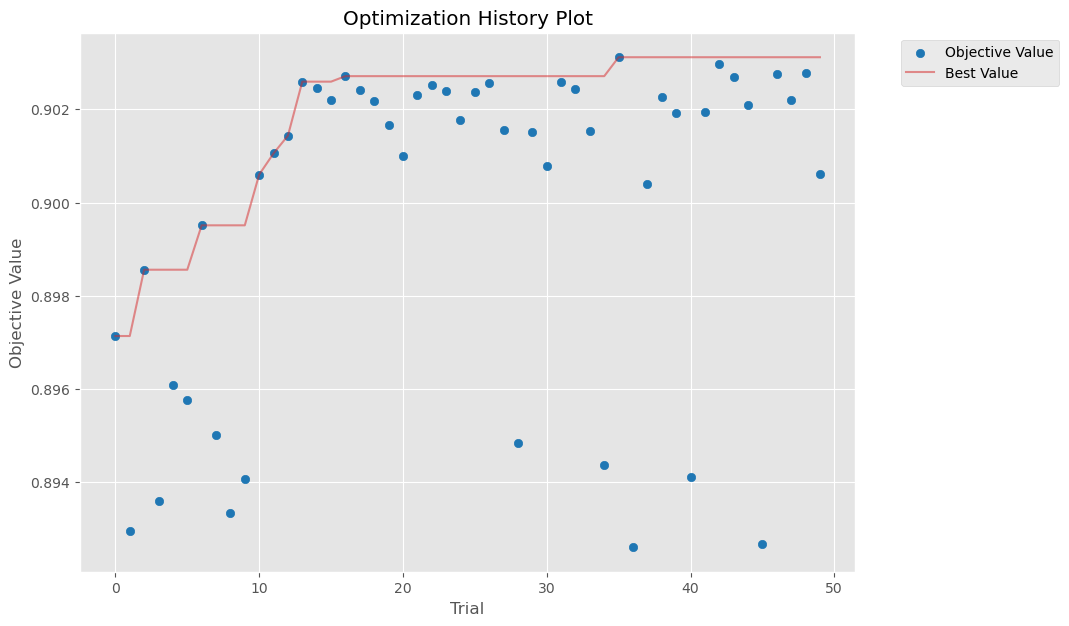

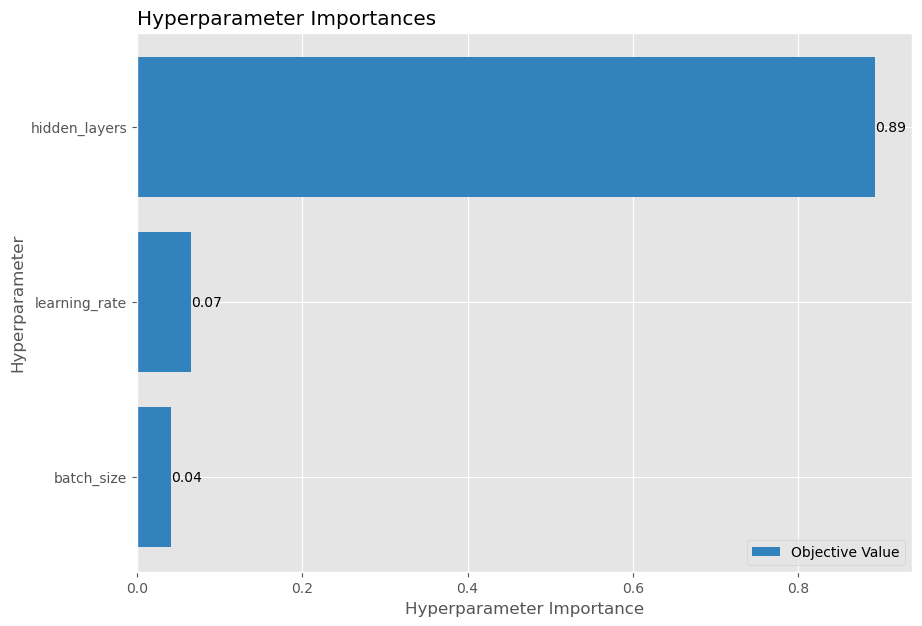

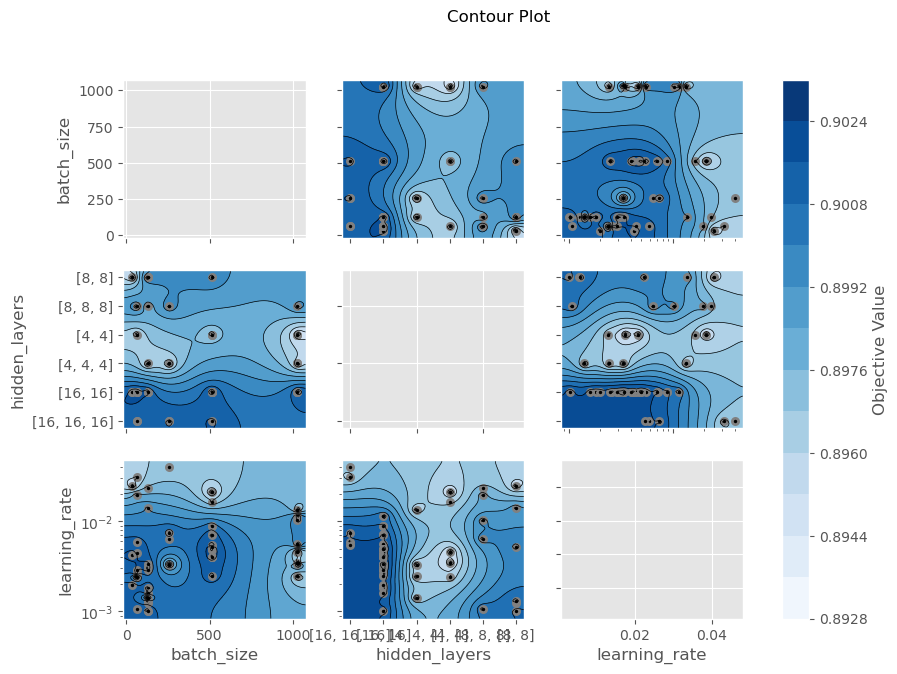

In [105]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study) 
fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

[I 2025-01-26 11:53:57,510] A new study created in memory with name: no-name-26039a00-18e6-4b1d-9eab-6e0ec147245f
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2025-01-26 11:53:57,520] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Filtered trials for hidden_layers=(4, 4): 5


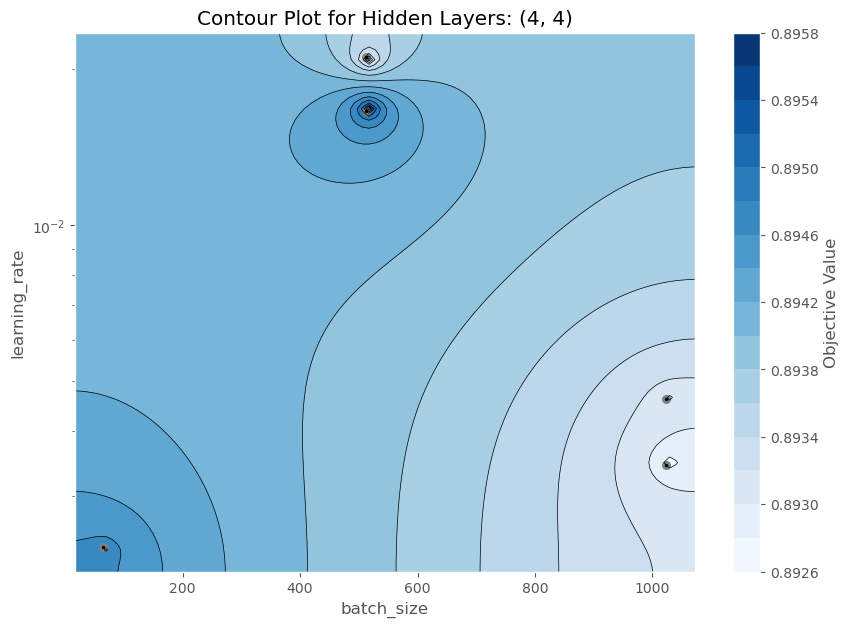

[I 2025-01-26 11:53:57,954] A new study created in memory with name: no-name-42093c77-5c0b-4518-a2de-d23ef516e61e
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2025-01-26 11:53:57,955] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Filtered trials for hidden_layers=(8, 8): 6


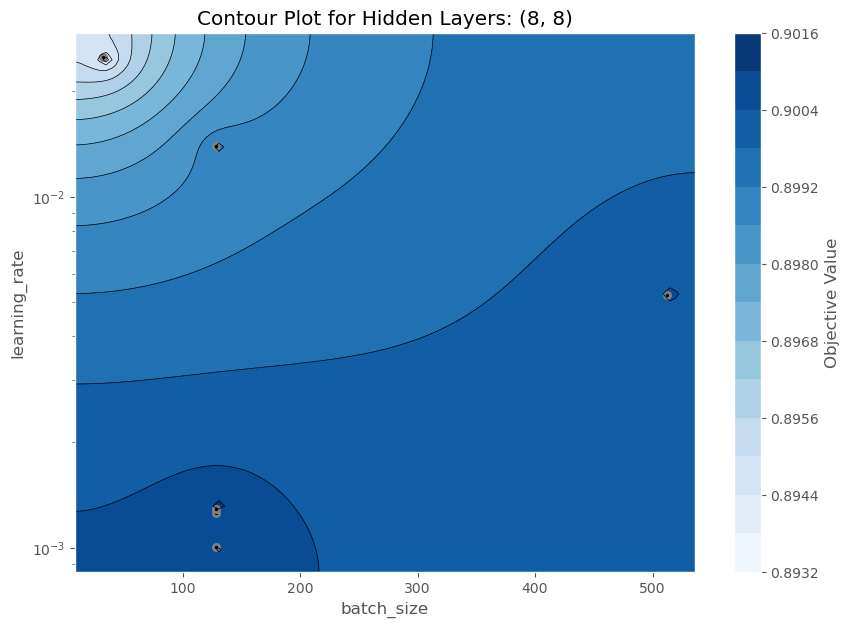

[I 2025-01-26 11:53:58,360] A new study created in memory with name: no-name-c3f6ae09-d8d4-4284-a784-00d888cf573c
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2025-01-26 11:53:58,362] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Filtered trials for hidden_layers=(16, 16): 25


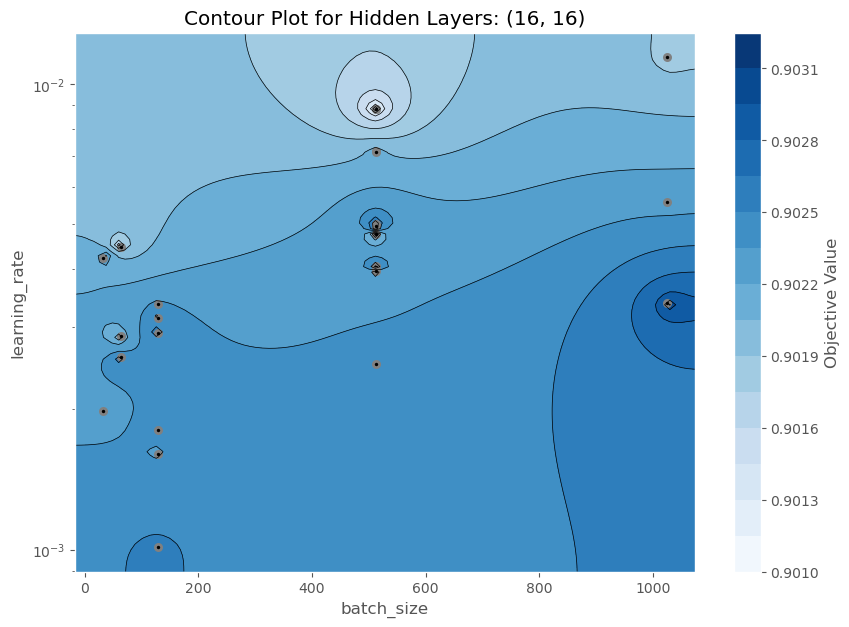

[I 2025-01-26 11:53:58,853] A new study created in memory with name: no-name-16b0d7eb-fa94-484f-ac91-2a3ae4e60081
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2025-01-26 11:53:58,854] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Filtered trials for hidden_layers=(16, 16, 16): 5


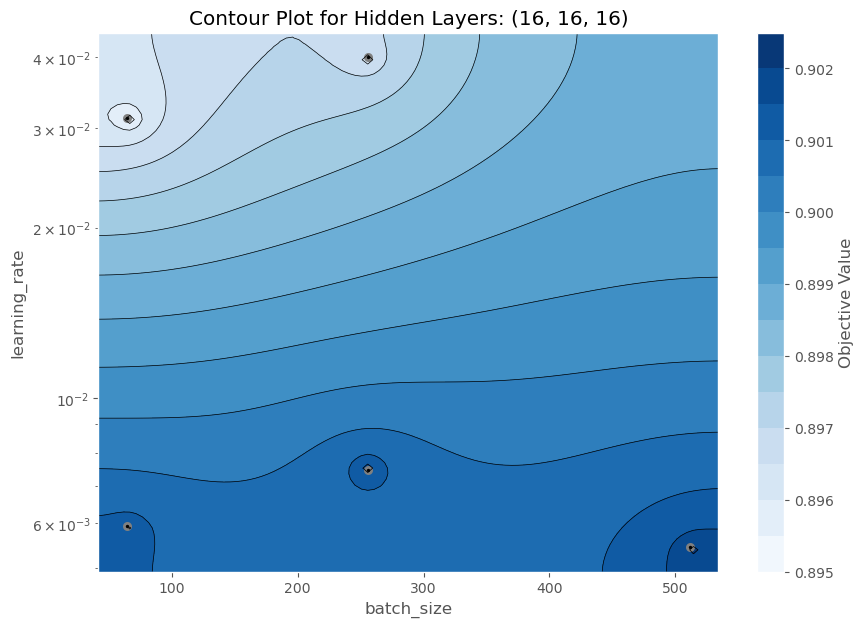

[I 2025-01-26 11:53:59,407] A new study created in memory with name: no-name-e0a67a4a-2e8c-4584-ad15-d6006a61cfa2
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2025-01-26 11:53:59,407] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Filtered trials for hidden_layers=(4, 4, 4): 4


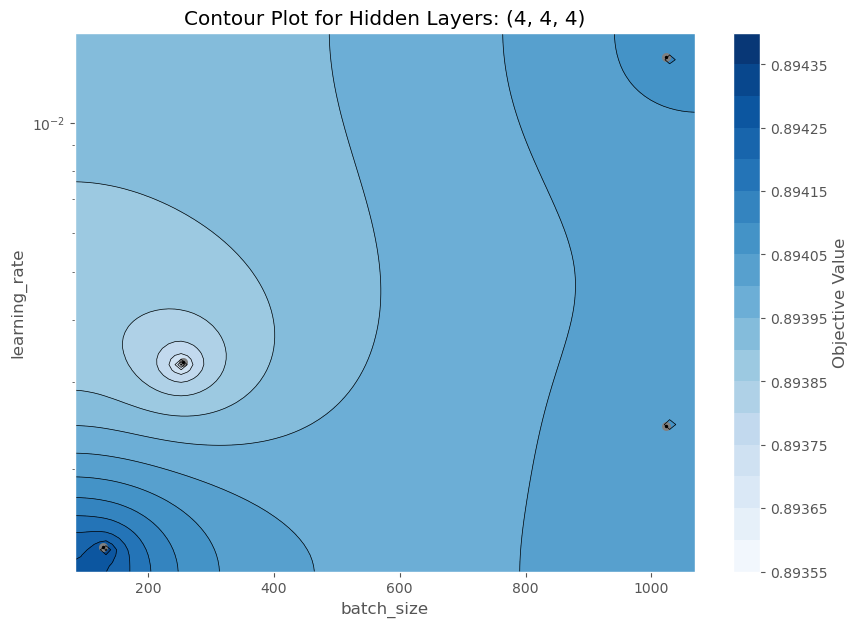

[I 2025-01-26 11:53:59,830] A new study created in memory with name: no-name-2a55879f-1258-46d9-9a35-197c33d57f8f
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2025-01-26 11:53:59,831] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Filtered trials for hidden_layers=(8, 8, 8): 5


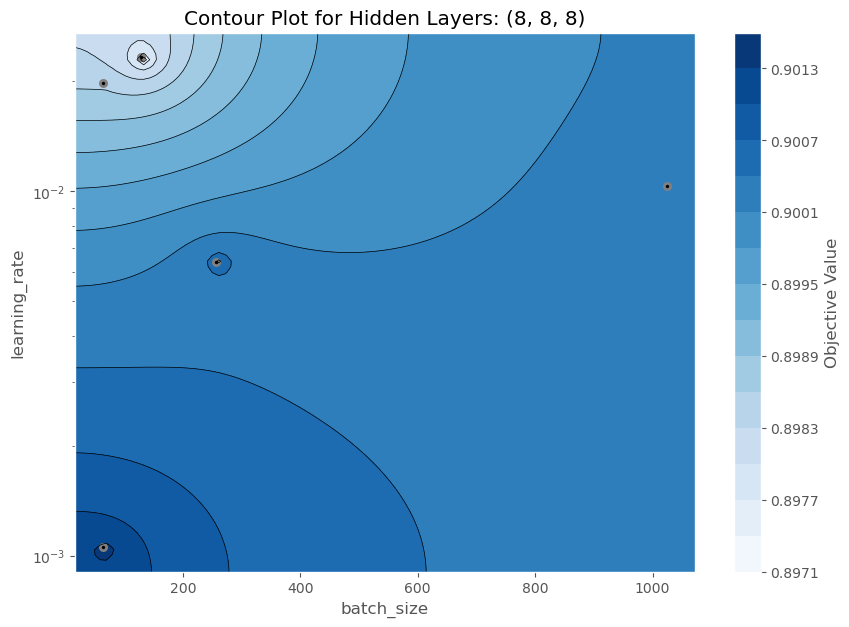

In [114]:
import optuna.visualization.matplotlib

# Genera il contour plot per ogni configurazione di hidden_layers
for hidden_layers in hidden_layer_configs:
    # Filtra i trial per questa configurazione di hidden_layers
    filtered_trials = [
        trial for trial in study.trials if trial.params.get("hidden_layers") == list(hidden_layers)
    ]
    print(f"Filtered trials for hidden_layers={hidden_layers}: {len(filtered_trials)}")
    # Crea uno studio temporaneo con i trial filtrati
    if filtered_trials:
        filtered_study = optuna.create_study(direction=study.direction)
        filtered_study.add_trials(filtered_trials)

        # Genera il contour plot per learning rate e batch size
        fig = optuna.visualization.matplotlib.plot_contour(
            filtered_study,
            params=["learning_rate", "batch_size"]
        )
        plt.title(f"Contour Plot for Hidden Layers: {hidden_layers}")
        plt.show()
    else:
        print(f"Nessun dato per hidden_layers={hidden_layers}")


### **Feature importance** <font color='red'>(not working)</font>

In [ ]:
import numpy as np
import pandas as pd
import torch
import shap
import matplotlib.pyplot as plt
from sklearn.utils import resample
import pandas as pd
import numpy as np
from sklearn.utils import resample

def plot_feature_impNN(X, y, model, labels=None, feature_names=None, n_sample=10000):
    """
    Calcola l'importanza delle feature usando SHAP per una rete neurale.
    
    X: torch.Tensor o pd.DataFrame
        Dataset delle feature.
    y: torch.Tensor o pd.Series
        Label target.
    model: PyTorch model
        Modello di rete neurale addestrato.
    labels: list
        Etichette da mostrare nella legenda.
    feature_names: list
        Nomi delle feature.
    n_sample: int
        Numero massimo di campioni da utilizzare per calcolare SHAP.
    """
    # Convertire X in DataFrame se è un torch.Tensor
    if isinstance(X, torch.Tensor):
        X_df = pd.DataFrame(X.numpy(), columns=feature_names)
    else:
        X_df = X

    # Convertire y in Series se è un torch.Tensor
    if isinstance(y, torch.Tensor):
        y_series = pd.Series(y.numpy())
    else:
        y_series = y

    # Calcolare il numero di classi e i campioni per classe
    class_labels, class_counts = np.unique(y_series, return_counts=True)
    n_classes = len(class_labels)
    n_sample = min(n_sample, *class_counts)

    # Sottocampionare il dataset
    subsampled_data = []
    for class_lab in class_labels:
        mask = y_series == class_lab
        class_data = X_df[mask]
        class_data = class_data.sample(n=n_sample, random_state=42)  # Pandas sampling
        subsampled_data.append(class_data)

    # Concatenare i sottocampioni
    df_subs = pd.concat(subsampled_data).reset_index(drop=True)
    X_subs = torch.tensor(df_subs.values, dtype=torch.float32)

    # Creare un explainer SHAP
    explainer = shap.DeepExplainer(model, X_subs)
    shap_values = explainer.shap_values(X_subs)

    # Creare i grafici SHAP
    res = []
    if n_classes <= 2:
        res.append(plt.figure(figsize=(18, 9)))
        shap.summary_plot(shap_values, df_subs, feature_names=feature_names, show=False)
    else:
        for i_class in range(n_classes):
            res.append(plt.figure(figsize=(18, 9)))
            shap.summary_plot(
                shap_values[i_class],
                df_subs,
                feature_names=feature_names,
                show=False
            )

    res.append(plt.figure(figsize=(18, 9)))
    shap.summary_plot(
        shap_values,
        df_subs,
        plot_type="bar",
        feature_names=feature_names,
        show=False,
    )

    return res


In [ ]:

shap_figs = plot_feature_impNN(X_test, y_test, model, labels=leg_labels, feature_names=vars_to_draw)  

# only show the SHAP summary plot
#plt.close(shap_figs[0])
#plt.close(shap_figs[1])
#plt.close(shap_figs[2])
plt.show() 